In [ ]:
# 1 # Checking the GPU connected to the session
!nvidia-smi

Thu Jul  8 11:05:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# 2 # Project name
PROJECT_NAME = '95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256'

In [ ]:
# 3 # Copying the prepared sources to create a training dataset
from google.colab import drive
drive.mount('/content/drive')

name = 'faces_ms1m-refine-v2_112x112_jpg.zip'
db_path = 'drive/My Drive/Colab Notebooks/db/diplom'
print('Copying the source dataset ...', name)
!cp "{db_path}/{name}" .
!unzip -o -q "{name}"
!rm "{name}"
name = 'mmod_human_face_detector.dat'
print('Copying Dlib Face Detector weights ...', name)
!cp "{db_path}/{name}" .

Mounted at /content/drive
Copying the source dataset ... faces_ms1m-refine-v2_112x112_jpg.zip
Copying Dlib Face Detector weights ... mmod_human_face_detector.dat


In [2]:
# 4 # Copying training and validation datasets
from google.colab import drive
drive.mount('/content/drive')

#name = 'ms1mv2_bin_dlib_continued.tfrecord'
name = 'ms1mv2_bin_mtcnn_sq_continued.tfrecord'
db_path = 'drive/My Drive/Colab Notebooks/db/diplom'
print('Copying the training dataset ...', name)
!cp "{db_path}/{name}" .
name = 'lfw_dlib.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'agedb_30_dlib.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'friends_16_test_dlib.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'test_photos14_dlib.zip'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
!unzip -o -q "{name}"
name = 'mmod_human_face_detector.dat'
print('Copying Dlib Face Detector weights ...', name)
!cp "{db_path}/{name}" .

Mounted at /content/drive
Copying the training dataset ... ms1mv2_bin_mtcnn_sq_continued.tfrecord
Copying the validation dataset ... lfw_dlib.bin
Copying the validation dataset ... agedb_30_dlib.bin
Copying the validation dataset ... friends_16_test_dlib.bin
Copying the validation dataset ... test_photos14_dlib.zip
Copying Dlib Face Detector weights ... mmod_human_face_detector.dat


In [ ]:
# 5 # Copying additional datasets for stage 6
name = 'lfw_mtcnn_sq.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'agedb_30_mtcnn_sq.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'friends_16_test_mtcnn_sq.bin'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
name = 'test_photos15_mtcnn_sq.zip'
print('Copying the validation dataset ...', name)
!cp "{db_path}/{name}" .
!unzip -o -q "{name}"

Copying the validation dataset ... lfw_mtcnn_sq.bin
Copying the validation dataset ... agedb_30_mtcnn_sq.bin
Copying the validation dataset ... friends_16_test_mtcnn_sq.bin
Copying the validation dataset ... test_photos15_mtcnn_sq.zip


In [ ]:
# 6 # Copying the model weights
name = 'checkpoints_{}.zip'.format(PROJECT_NAME)
db_path = 'drive/My Drive/Colab Notebooks/db/diplom'
print('Preparing the model weights ...', name)
!cp "{db_path}/{name}" .
!unzip -o -q "{name}"

Preparing the model weights ... checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip


In [2]:
# 7 # Training assistant function
def copy_to_google_drive(path):
  name = 'checkpoints_{}.zip'.format(PROJECT_NAME)
  print('Copying the weights \"{}\" to Google Drive ...'.format(name))
  !zip -r "{name}" "{path}"
#  !cp "{name}" 'drive/My Drive/Colab Notebooks/db/diplom'

In [3]:
# 8 # Setting the configuration parameters
# Setting the main source of the dataset
source_dataset = {
    'path': 'faces_emore_jpg',
    'align': True,
    'align_error_continue': True,
    'align_error_delete': False,
#    'num_classes': 100,
#    'random_classes': True,
#    'num_samples': 100,
}

# A set of datasets for validation during training
val_datasets = [
    {'name': 'Friends 16',
     'path': 'friends_16_test_dlib.bin'},
    {'name': 'LFW',
     'path': 'lfw_dlib.bin'},
    {'name': 'AgeDB30',
     'path': 'agedb_30_dlib.bin'}]

val_datasets_mixed = [
    {'name': 'Friends 16',
     'path': 'friends_16_test_dlib.bin'},
    {'name': 'LFW',
     'path': 'lfw_dlib.bin'},
    {'name': 'AgeDB30',
     'path': 'agedb_30_dlib.bin'},
    {'name': 'F16 mtcnn',
     'path': 'friends_16_test_mtcnn_sq.bin'},
    {'name': 'LFW mtcnn',
     'path': 'lfw_mtcnn_sq.bin'},
    {'name': 'Age mtcnn',
     'path': 'agedb_30_mtcnn_sq.bin'}]

# A set of datasets for testing the classifier during training
clf_datasets = [
    {'name': 'Classifier',
     'clf_type': 'svc_lin',
     'train_path': r'test_photos14_dlib/train',
     'test_path': r'test_photos14_dlib/test',
     'align': True}]

clf_datasets_mixed = [
    {'name': 'Classifier',
     'clf_type': 'svc_lin',
     'train_path': r'test_photos14_dlib/train',
     'test_path': r'test_photos14_dlib/test',
     'align': True},
    {'name': 'Clf mtcnn',
     'clf_type': 'svc_lin',
     'train_path': r'test_photos15_mtcnn_sq/train',
     'test_path': r'test_photos15_mtcnn_sq/test',
     'align': True}]

# Standard set of datasets for testing in carray format
test_carray_datasets = [
    {'name': 'Friends 16',
     'path': r'E:\Deep Learning\data\test\friends_16_test.np.carray\test_data'},
    {'name': 'LFW',
     'path': r'E:\Deep Learning\data\test\lfw_align_112\lfw',
     'align': False,
     'align_error_continue': False,
     'align_error_delete': False},
    {'name': 'AgeDB30',
     'path': r'E:\Deep Learning\data\test\agedb_align_112\agedb_30'},
    {'name': 'CFP-FP',
     'path': r'E:\Deep Learning\data\test\cfp_align_112\cfp_fp'}]

# Standard set of datasets for testing in binary format
test_dlib_binary_datasets = [
    {'name': 'Friends 16',
     'path': 'friends_16_test_dlib.bin'},
    {'name': 'LFW',
     'path': 'lfw_dlib.bin',
     'align': False,
     'align_error_continue': False,
     'align_error_delete': False},
    {'name': 'AgeDB30',
     'path': 'agedb_30_dlib.bin',
     'align': False,
     'align_error_continue': False,
     'align_error_delete': False,
     'align_manual': {
         '1799': [14, 27, 99, 112]}}]

test_mtcnn_sq_binary_datasets = [
    {'name': 'Friends 16',
     'path': 'friends_16_test_mtcnn_sq.bin'},
    {'name': 'LFW',
     'path': 'lfw_mtcnn_sq.bin',
     'align': False,
     'align_error_continue': False,
     'align_error_delete': False,
     'align_manual': {
         '11217': [20, 13, 109, 111]}},
    {'name': 'AgeDB30',
     'path': 'agedb_30_mtcnn_sq.bin',
     'align': False,
     'align_error_continue': False,
     'align_error_delete': False,
     'align_manual': {
         '158': [10, 15, 90, 112],
         '653': [10, 15, 90, 112],
         '830': [10, 15, 90, 112],
         '586': [22, 0, 112, 112],
         '687': [22, 0, 112, 112],
         '703': [22, 0, 112, 112],
         '789': [22, 0, 112, 112],
         '1143': [22, 0, 112, 112],
         '1199': [22, 0, 112, 112],
         '1344': [18, 17, 99, 108],
         '1910': [18, 17, 99, 108],
         '2111': [18, 17, 99, 108],
         '3792': [12, 9, 101, 112],
         '4279': [12, 9, 101, 112],
         '4476': [12, 9, 101, 112],
         '8926': [19, 23, 92, 112],
         '9029': [19, 23, 92, 112],
         '9105': [19, 23, 92, 112],
         '9451': [19, 23, 92, 112],
         '9521': [19, 23, 92, 112],
         '9571': [19, 23, 92, 112],
         '9780': [0, 7, 84, 112],
         '11192': [15, 12, 98, 112]}}]

# Dataset for training the classifier
clf_train_dataset = {
    'path': r'test_photos14_dlib/train',
    'align': True}

# Dataset for testing the classifier
clf_test_dataset = {
    'path': r'test_photos14_dlib/test',
    'align': True}

# Main training profile
train_plan = { # (epochs, lr, val_save, val_per_epoch)
    'plan': ((8, 0.01, False, 1), (6, 0.005, False, 1), (8, 0.0025, True, 1),
             (10, 1e-3, True, 4), (10, 1e-4, True, 4), (10, 1e-5, True, 4)),
    'train_dataset': 'ms1mv2_bin_dlib_continued.tfrecord',
    'val_datasets': val_datasets_mixed,
    'clf_datasets': clf_datasets_mixed,
    'train_helper': copy_to_google_drive,
    'train_head': 'ArcFaceHead', # 'ArcFaceHead', 'CosFaceHead',
                                 # 'AdaCosHead', 'SphereFaceHead'
    'margin': 0.5, # 0.5 for ArcFace, 0.35 for CosFace, 1.35 for SphereFace
    'batch_size': 256,
    'train_crop': True,
    'pretrained': False,
    'num_classes': 85742,
    'num_samples': 5822653,     
    'logist_scale': 64} # for AdaCosHead this is "max_scale"

# Transfer Learning & Fine Tuning profile
learn_plan = { # (epochs, lr, val_save, val_per_epoch)
    'plan': ((10, 1e-6, True, 6), (10, 1e-7, True, 6)),
    'train_dataset': 'ms1mv2_bin_mtcnn_sq_continued.tfrecord',
    'val_datasets': val_datasets_mixed,
    'clf_datasets': clf_datasets_mixed,
    'train_helper': copy_to_google_drive,
    'train_head': 'ArcFaceHead', # 'ArcFaceHead', 'CosFaceHead',
                                 # 'AdaCosHead', 'SphereFaceHead'
    'margin': 0.5, # 0.5 for ArcFace, 0.35 for CosFace, 1.35 for SphereFace
    'batch_size': 256,
    'train_crop': True,
    'num_classes': 85742,
    'num_samples': 5822653,
    'logist_scale': 64} # for AdaCosHead this is "max_scale"

# Main configuration
cfg = {
    # General
    'net_type': 'MobileFaceNetV2', # 'ResNet34', 'ResNet34R', 'ResNet50'
        # 'ResNet101', 'MobileNetV2', 'MobileFaceNetV2',
        # 'Seesaw_shuffleFaceNet'
    'input_size': 112,
    'embd_shape': 512,
    'debug': False,
    # Data preparation
    'train_build_dataset': 'ms1mv2_bin_dlib_continued.tfrecord',
    'test_build_path': '',
    'test_build_name': 'friends_16_test_dlib.bin',
    'test_build_prefix': 'test_data',
    'test_split': 0,
    'test_samples': 0,
    'test_max_pairs': 3000,
    'face_detector_type': 'dlib', # 'MTCNN' or 'dlib'
    'face_detector_prob': 0.4,
    'face_detector_square': False,
    'binary_img': True,
    # Training
    'train_plan': train_plan,
    'learn_plan': learn_plan,
    'fine_tuning': True,
    'normalization': '-1:1', # '0:1', '-1:1', '-0.99:0.99', '0:255'
    'w_decay': 1e-9, #5e-4, 1e-6, 1e-8
    # Testing
    'test_datasets': test_dlib_binary_datasets,
    'test_batch_size': 16,  
    'test_crop': False,
    'clf_type': 'svc_lin', # 'svc_lin', 'svc_rbf', 'knc', 'rfc', 'gscv'
                           # 'pearson', 'cosine', 'l2', 'l1'
    'clf_train_dataset': clf_train_dataset,
    'clf_test_dataset': clf_test_dataset,
    'img_path': None}

In [ ]:
# 9 # Installing the required packages
!pip install --upgrade tensorflow==2.4.1
!pip install tensorflow_addons bcolz facenet-pytorch

     |████████████████████████████████| 394.3MB 22kB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
     |████████████████████████████████| 471kB 53.2MB/s 
     |████████████████████████████████| 3.8MB 42.8MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 686kB 14.9MB/s 
     |████████████████████████████████| 1.5MB 23.5MB/s 
     |██████████████████

In [4]:
# 10 # Importing libraries
import math
import os
import sys
import cv2
import glob
import random
import bcolz
import shutil
import pickle
import itertools
import logging
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow.keras.applications as applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, \
    BatchNormalization, Layer, Conv2D, ReLU, DepthwiseConv2D, Add, \
    Concatenate, Lambda, PReLU, Activation, Reshape
from tensorflow.keras.activations import sigmoid
from tensorflow_addons.layers import AdaptiveAveragePooling2D
from tensorflow.python.keras.layers import VersionAwareLayers
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework.convert_to_constants import \
    convert_variables_to_constants_v2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Markdown

if cfg['face_detector_type'] == 'dlib':
  import dlib
elif cfg['face_detector_type'] == 'MTCNN':
  import torch
  from facenet_pytorch import MTCNN

In [5]:
# 11 # Project functions and classes
# Setting global constants
IMG_ALIGNED_PREF = 'aligned'
DLIB_FACE_DETECTION_MODEL = 'mmod_human_face_detector.dat'
CLF_CLFER = 'classifier.pkl'
CLF_DATA = 'data.pkl'
CLF_OTHERS = 'Others'
CHECKPOINTS_PATH = './checkpoints'


# Markdown printing
def printmd(string):
  display(Markdown(string))


# Exception for the face detector configuration parameter
def raise_face_detector_type():
  raise Exception('Configuration parameter \"face_detector_type\"'
                  ' is set incorrectly.')


# Create a face detector object
def create_face_detector(cfg):
  if cfg['face_detector_type'] == 'MTCNN':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    cfg['face_detector'] = MTCNN(
        select_largest=False, selection_method="probability", device=device)
  elif cfg['face_detector_type'] == 'dlib':
    cfg['face_detector'] = dlib.cnn_face_detection_model_v1(
        DLIB_FACE_DETECTION_MODEL)
  else:
    raise_face_detector_type()


# Freeing the face detector object to free up GPU memory
def free_face_detector(cfg):
  del(cfg['face_detector'])
  if cfg['face_detector_type'] == 'MTCNN':
    torch.cuda.empty_cache()


# Getting a list of labels of the dataset
def get_dataset_labels(dataset, verbose=True):
  labels = []
  if 'path' in dataset:
    labels = sorted([p for p in os.listdir(dataset['path'])
                     if os.path.isdir(os.path.join(dataset['path'], p))])
    if verbose:
      print('There are {} labels found in the \"{}\" directory.'
            .format(len(labels), dataset['path']))
  return labels


# Image decoding function
def decode_image(data):
  return cv2.imdecode(data, cv2.IMREAD_COLOR)


# Image loading function
def load_image(img_path):
  img = decode_image(np.fromfile(img_path, dtype=np.uint8))
  if img is None:
    raise Exception('Error loading image:', img_path)
    
  return img


# Initializing alignment statistics
def init_align_stats(dataset):
  dataset['align_continued'] = 0
  dataset['align_deleted'] = 0


# Print alignment statistics
def print_align_stats(dataset):
  if dataset['align_continued'] > 0:
    print('Number of images without detected faces:',
          dataset['align_continued'])
  if dataset['align_deleted'] > 0:
    print('Number of deleted images without detected faces:',
          dataset['align_deleted'])
  if dataset['align_continued'] > 0 or dataset['align_deleted'] > 0:
    print()


# Find the face in the image and crop it
def align_face_image(cfg, dataset, img, label):

  # If the face is not found in the image
  def face_not_found(img):
    msg = 'Face not found in image "{}"'.format(label)
    align_error_continue = 'align_error_continue' in dataset and \
        dataset['align_error_continue']
    align_error_delete = 'align_error_delete' in dataset and \
        dataset['align_error_delete']
    print(msg)
    if cfg['debug']:
      imshow_bgr(img)
    if not (align_error_continue or align_error_delete):
      raise Exception(msg)
    if align_error_continue:
      dataset['align_continued'] += 1
    if align_error_delete:
      dataset['align_deleted'] += 1

  # The function of scaling the bounding box with a face
  def scale_box(x1, y1, x2, y2):
    if cfg['face_detector_square']:
      height, width = y2 - y1, x2 - x1
      margin = abs(height - width) / 4
      if height > width:
        x1 -= margin
        y1 += margin
        x2 += margin
        y2 -= margin
      else:
        x1 += margin
        y1 -= margin
        x2 -= margin
        y2 += margin

    return (int(x1), int(y1), int(x2), int(y2))      

  # Image alignment function
  def align_img(img, x1, y1, x2, y2):
    x1, y1, x2, y2 = scale_box(x1, y1, x2, y2)
    img = img[max(0, int(y1)):max(0, int(y2)),
              max(0, int(x1)):max(0, int(x2))]    
    return cv2.resize(img, (cfg['input_size'], cfg['input_size']),
                      interpolation = cv2.INTER_CUBIC)
  
  
  face_found = True
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if 'align_manual' in dataset and str(label) in dataset['align_manual']:
    (x1, y1, x2, y2) = dataset['align_manual'][str(label)]
    img_before = img
    img = align_img(img, x1, y1, x2, y2)
    print('The image "{}" is aligned manually.'.format(label))
    if cfg['debug']:
      imshow_bgr(img_before)
      imshow_bgr(img)
  elif cfg['face_detector_type'] == 'MTCNN':
    boxes, probs = cfg['face_detector'].detect(img_rgb)
    if boxes is not None and probs[0] > cfg['face_detector_prob']:
      (x1, y1, x2, y2) = boxes[0]
      img = align_img(img, int(x1), int(y1), int(x2), int(y2))
    else:
      face_found = False
      face_not_found(img)
      
  elif cfg['face_detector_type'] == 'dlib':
    boxes = cfg['face_detector'](img_rgb, 1)
    if boxes:
      box = boxes[0]
      img = align_img(img, box.rect.left(), box.rect.top(),
                      box.rect.right(), box.rect.bottom())
    else:
      face_found = False
      face_not_found(img)
    
  else:
    raise_face_detector_type()

  return (img, face_found)


# Find the face in the image file and crop it
def align_face_imagefile(cfg, dataset, img_path):
  align_error_delete = 'align_error_delete' in dataset and \
      dataset['align_error_delete']
  img = load_image(img_path)
  img, face_found = align_face_image(cfg, dataset, img, img_path)
  if face_found:
    (filename, fileext) = os.path.splitext(img_path)
    img_path_new = filename + '_' + IMG_ALIGNED_PREF + fileext
    _, buff = cv2.imencode('.jpg', img)
    img = decode_image(np.frombuffer(buff, dtype=np.uint8))
    buff.tofile(img_path_new)
    os.remove(img_path)
  else:
    img_path_new = img_path
  if not face_found and align_error_delete:
    os.remove(img_path)

  return (img, face_found, img_path_new)


# The function of creating the Backbone model ResNet34
def ResNet34(input_shape, use_bias=True, alpha=1.0, bn_axis=3,
             name='ResNet34'):
  
  def build_block(x, filters, kernel_size=3, stride=1,
                  conv_shortcut=True, name=None):
    if conv_shortcut:
      shortcut = layers.Conv2D(
          filters, 1, strides=stride, name=name + '_0_conv')(x)
      shortcut = layers.BatchNormalization(
          axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    else:
      shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

  
  def build_stack(x, filters, blocks, stride1=2, name=None):
    x = build_block(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
      x = build_block(x, filters, conv_shortcut=False,
                      name=name + '_block' + str(i))
    return x  

  
  layers = VersionAwareLayers()
  img_input = layers.Input(shape=input_shape)
  x = layers.ZeroPadding2D(
      padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
  x = layers.Conv2D(64 * alpha, 7, strides=2, use_bias=use_bias,
                    name='conv1_conv')(x)
  x = layers.BatchNormalization(
      axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
  x = layers.Activation('relu', name='conv1_relu')(x)
  x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
  x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)
  x = build_stack(x, 64 * alpha, 3, stride1=1, name='conv2')
  x = build_stack(x, 128 * alpha, 4, name='conv3')
  x = build_stack(x, 256 * alpha, 6, name='conv4')
  x = build_stack(x, 512 * alpha, 3, name='conv5')
  model = training.Model(img_input, x, name=name)
  return model


# The function of creating the Backbone model MobileFaceNetV2
def MobileFaceNetV2(input_shape, name='MobileFaceNetV2', w_decay=4e-5):
  
  def conv_block(inputs, filters, kernel, strides, padding='same',
                 use_bias=False, linear=False):
    x = Conv2D(filters, kernel, strides=strides, padding=padding,
               use_bias=use_bias, kernel_initializer='glorot_normal',
               kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    if not linear:
      x = ReLU()(x)
    return x

  def dw_conv_block(inputs, kernel, strides, padding='same',
                    use_bias=False, linear=False):
    x = DepthwiseConv2D(kernel, strides=strides, padding=padding,
                        use_bias=use_bias,
                        depthwise_initializer='glorot_normal',
                        depthwise_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    if not linear:
      x = ReLU()(x)
    return x

  def depth_wise_block(inputs, out_dim, kernel, strides, groups,
                       residual=False):
    x = conv_block(inputs, groups, kernel=(1, 1), strides=(1, 1))
    x = dw_conv_block(x, kernel=kernel, strides=strides)
    x = conv_block(x, out_dim, kernel=(1, 1), strides=(1, 1), linear=True)
    if residual:
      x = Add()([x, inputs])
    return x

  def residual_block(inputs, out_dim, kernel, strides, groups, num_block):
    x = inputs
    for _ in range(num_block):
      x = depth_wise_block(x, out_dim, kernel, strides, groups, residual=True)
    return x

  reg = tf.keras.regularizers.l2(w_decay)
  image_inputs = Input(shape=input_shape)
  net = conv_block(image_inputs, 64, kernel=(3, 3), strides=(2, 2))
  net = dw_conv_block(net, kernel=(3, 3), strides=(1, 1))
  net = depth_wise_block(net, 64, kernel=(3, 3), strides=(2, 2), groups=128)
  net = residual_block(net, 64, kernel=(3, 3), strides=(1, 1), groups=128,
                       num_block=4)
  net = depth_wise_block(net, 128, kernel=(3, 3), strides=(2, 2), groups=256)
  net = residual_block(net, 128, kernel=(3, 3), strides=(1, 1), groups=256,
                       num_block=6)  
  net = depth_wise_block(net, 128, kernel=(3, 3), strides=(2, 2), groups=512)
  net = residual_block(net, 128, kernel=(3, 3), strides=(1, 1), groups=256,
                       num_block=2)  
  net = conv_block(net, 512, kernel=(1, 1), strides=(1, 1), use_bias=True)
  net = dw_conv_block(net, kernel=(7, 7), strides=(1, 1), padding='valid',
                      linear=True)
  model = Model(image_inputs, net, name=name)
  return model   


# The function of creating the Backbone model Seesaw-shuffleFaceNet
def Seesaw_shuffleFaceNet(input_shape, name='Seesaw-shuffleFaceNet',
                          w_decay=4e-5):
  
  def conv_block(inputs, filters, kernel, strides, padding='same'):
    x = Conv2D(filters, kernel, strides=strides, padding=padding,
               use_bias=False, kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    return x * sigmoid(x)

  def linear_block(inputs, filters, kernel, strides, padding='same'):
    x = Conv2D(filters, kernel, strides=strides, padding=padding,
               use_bias=False, kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    return x

  def dw_conv_block(inputs, kernel, strides, padding='same'):
    x = DepthwiseConv2D(kernel, strides=strides, padding=padding,
                        use_bias=False, depthwise_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    return x * sigmoid(x)

  def dw_linear_block(inputs, kernel, strides, padding='same'):
    x = DepthwiseConv2D(kernel, strides=strides, padding=padding,
                        use_bias=False, depthwise_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    return x

  def permutation_block(inputs, groups):
    n, h, w, c = inputs.shape
    x = Reshape((h, w, groups, c//groups))(inputs)
    x = tf.transpose(x, [0, 1, 2, 4, 3])
    x = Reshape((h, w, c))(x)
    return x
  
  def se_block(inputs, groups, reduction=4):
    x = AdaptiveAveragePooling2D(1)(inputs)
    x = Reshape((x.shape[3],))(x)
    x = Dense(groups // reduction, kernel_regularizer=reg)(x)
    x = PReLU()(x)
    x = Dense(groups, kernel_regularizer=reg)(x)
    x = sigmoid(x)
    x = Reshape((1, 1, x.shape[1]))(x)
    return inputs * x

  def depth_wise_block(inputs, out_dim, kernel, strides, groups,
                       residual=False):
    x = inputs
    x1 = Lambda(lambda x: x[:, :, :, :(x.shape[-1]//4)])(x)
    x2 = Lambda(lambda x: x[:, :, :, (x.shape[-1]//4):])(x)
    x1 = conv_block(x1, groups//4, kernel=(1, 1), strides=(1, 1))
    x2 = conv_block(x2, groups*3//4, kernel=(1, 1), strides=(1, 1))
    x = Concatenate()((x1, x2))
    x = permutation_block(x, 2)
    x = dw_conv_block(x, kernel=kernel, strides=strides)
    x = se_block(x, groups)
    x1 = Lambda(lambda x: x[:, :, :, :(x.shape[-1]//4)])(x)
    x2 = Lambda(lambda x: x[:, :, :, (x.shape[-1]//4):])(x)
    x1 = linear_block(x1, out_dim//4, kernel=(1, 1), strides=(1, 1))
    x2 = linear_block(x2, out_dim*3//4, kernel=(1, 1), strides=(1, 1))
    x = Concatenate()((x1, x2))
    if residual:
      x = Add()([x, inputs])
    return x

  def residual_block(inputs, out_dim, kernel, strides, groups, num_block):
    x = inputs
    for _ in range(num_block):
      x = depth_wise_block(x, out_dim, kernel, strides, groups, residual=True)
    return x

  reg = tf.keras.regularizers.l2(w_decay)
  image_inputs = Input(shape=input_shape)
  net = conv_block(image_inputs, 64, kernel=(3, 3), strides=(2, 2))
  net = dw_conv_block(net, kernel=(3, 3), strides=(1, 1))
  net = depth_wise_block(net, 64, kernel=(3, 3), strides=(2, 2), groups=128)
  net = residual_block(net, 64, kernel=(3, 3), strides=(1, 1), groups=128,
                       num_block=4)
  net = depth_wise_block(net, 128, kernel=(3, 3), strides=(2, 2), groups=256)
  net = residual_block(net, 128, kernel=(3, 3), strides=(1, 1), groups=256,
                       num_block=6)  
  net = depth_wise_block(net, 128, kernel=(3, 3), strides=(2, 2), groups=512)
  net = residual_block(net, 128, kernel=(3, 3), strides=(1, 1), groups=256,
                       num_block=2)  
  net = conv_block(net, 512, kernel=(1, 1), strides=(1, 1))
  net = dw_linear_block(net, kernel=(7, 7), strides=(1, 1), padding='valid')
  model = Model(image_inputs, net, name=name)
  return model   


# A function that returns the augmentation function during training
def _transform_images(norm_fwd, train_crop=True, input_size=112):
  def transform_images(x_train):
    x_train = tf.cast(x_train, tf.float32)
    if train_crop:
      re_size = tf.random.uniform(shape=[], minval=input_size,
                                  maxval=input_size+17, dtype=tf.int32)
      x_train = tf.image.resize(x_train, (re_size, re_size))
      x_train = tf.image.random_crop(x_train, (input_size, input_size, 3))
    x_train = tf.image.random_flip_left_right(x_train)
    x_train = tf.image.random_saturation(x_train, 0.6, 1.4)
    x_train = tf.image.random_brightness(x_train, 0.4)
    x_train = norm_fwd(x_train)
    return x_train
  return transform_images


# The output is returned unchanged
def _transform_targets(y_train):
  return y_train


# Function that returns the function of parsing the TFRecord during training
def _parse_tfrecord(norm_fwd, binary_img=False, train_crop=True,
                    input_size=112):
  def parse_tfrecord(tfrecord):
    if binary_img:
      features = {'image/source_id': tf.io.FixedLenFeature([], tf.int64),
                  'image/filename': tf.io.FixedLenFeature([], tf.string),
                  'image/encoded': tf.io.FixedLenFeature([], tf.string)}
      x = tf.io.parse_single_example(tfrecord, features)
      x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    else:
      features = {'image/source_id': tf.io.FixedLenFeature([], tf.int64),
                  'image/img_path': tf.io.FixedLenFeature([], tf.string)}
      x = tf.io.parse_single_example(tfrecord, features)
      image_encoded = tf.io.read_file(x['image/img_path'])
      x_train = tf.image.decode_jpeg(image_encoded, channels=3)
    y_train = tf.cast(x['image/source_id'], tf.float32)
    x_train = _transform_images(norm_fwd, train_crop=train_crop,
                                input_size=input_size)(x_train)
    y_train = _transform_targets(y_train)
    return (x_train, y_train), y_train
  return parse_tfrecord


# The function of loading a dataset in TFRecord format for training
def load_tfrecord_dataset(tfrecord_name, batch_size, norm_fwd,
                          binary_img=False, shuffle=True, buffer_size=10240,
                          train_crop=True, input_size=112):
  raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
  raw_dataset = raw_dataset.repeat()
  if shuffle:
    raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
  dataset = raw_dataset.map(
      _parse_tfrecord(norm_fwd, binary_img=binary_img, train_crop=train_crop,
                      input_size=input_size),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(
      buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset


# Training dataset loading function
def load_dataset(cfg, plan):
  if 'train_dataset' in plan and plan['train_dataset']:
    print('Loading the training dataset:', plan['train_dataset'])
    steps_per_epoch = plan['num_samples'] // plan['batch_size']
    dataset = load_tfrecord_dataset(
        plan['train_dataset'], plan['batch_size'], cfg['norm_fwd'],
        cfg['binary_img'], train_crop=plan['train_crop'],
        input_size=cfg['input_size'])
  else:
    raise Exception('The configuration parameter \"train_dataset\"'
                    ' is set incorrectly.')
  return (dataset, steps_per_epoch)


# Defining the custom ArcFacePenaltyLogists layer
class ArcFacePenaltyLogists(Layer):
  def __init__(self, num_classes, margin=0.5, logist_scale=64,
               regularizer=None, **kwargs):
    super(ArcFacePenaltyLogists, self).__init__(**kwargs)
    self.n_classes = num_classes
    self.s = float(logist_scale)
    self.m = float(margin)
    self.regularizer = regularizer

  def build(self, input_shape):
    embedding_shape, label_shape = input_shape
    self.w = self.add_weight(
        name='W', shape=(embedding_shape[-1], self.n_classes),
        initializer='glorot_uniform',
        trainable=True, regularizer=self.regularizer)

  def call(self, inputs):
    embedding, label = inputs
    label = tf.reshape(label, [-1])
    x = tf.nn.l2_normalize(embedding, axis=1)
    w = tf.nn.l2_normalize(self.w, axis=0)
    logits = tf.matmul(x, w)
    one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=self.n_classes)
    epsilon = tf.keras.backend.epsilon()
    theta = tf.math.acos(
        tf.keras.backend.clip(logits, -1.0 + epsilon, 1.0 - epsilon))
    selected_labels = tf.where(tf.greater(theta, math.pi - self.m),
                               tf.zeros_like(one_hot), one_hot)
    final_theta = tf.where(tf.cast(selected_labels, dtype=tf.bool),
                           theta + self.m, theta)
    output = tf.math.cos(final_theta)
    return self.s * output


# Defining the custom CosFacePenaltyLogists layer
class CosFacePenaltyLogists(Layer):
  def __init__(self, num_classes, margin=0.35, logist_scale=30,
               regularizer=None, **kwargs):
    super(CosFacePenaltyLogists, self).__init__(**kwargs)
    self.n_classes = num_classes
    self.s = float(logist_scale)
    self.m = float(margin)
    self.regularizer = regularizer

  def build(self, input_shape):
    embedding_shape, label_shape = input_shape
    self.w = self.add_weight(
        name='W', shape=(embedding_shape[-1], self.n_classes),
        initializer='glorot_uniform',
        trainable=True, regularizer=self.regularizer)

  def call(self, inputs):
    embedding, label = inputs
    label = tf.reshape(label, [-1])
    x = tf.nn.l2_normalize(embedding, axis=1)
    w = tf.nn.l2_normalize(self.w, axis=0)
    logits = tf.matmul(x, w)
    one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=self.n_classes)
    output = tf.where(tf.cast(one_hot, dtype=tf.bool),
                      logits - self.m, logits)
    return self.s * output


# Defining the custom AdaCosPenaltyLogists layer
class AdaCosPenaltyLogists(Layer):
  def __init__(self, num_classes, max_scale=64, is_dynamic=True,
               regularizer=None, **kwargs):
    super(AdaCosPenaltyLogists, self).__init__(**kwargs)
    self.n_classes = num_classes
    self.init_s = math.sqrt(2) * math.log(num_classes - 1)
    self.max_scale = max_scale
    self.is_dynamic = is_dynamic
    self.regularizer = regularizer

  def build(self, input_shape):
    embedding_shape, label_shape = input_shape
    self.w = self.add_weight(
        name='W', shape=(embedding_shape[-1], self.n_classes),
        initializer='glorot_uniform',
        trainable=True, regularizer=self.regularizer)
    if self.is_dynamic:
      self.s = self.add_weight(
          name='S', shape=(),
          initializer=tf.keras.initializers.Constant(self.init_s),
          trainable=False, aggregation=tf.VariableAggregation.MEAN)

  def call(self, inputs):
    embedding, label = inputs
    label = tf.reshape(label, [-1])
    x = tf.nn.l2_normalize(embedding, axis=1)
    w = tf.nn.l2_normalize(self.w, axis=0)
    logits = tf.matmul(x, w)
    if not self.is_dynamic:
      output = tf.multiply(self.init_s, logits)
      return output
    epsilon = tf.keras.backend.epsilon()
    theta = tf.math.acos(
        tf.keras.backend.clip(logits, -1.0 + epsilon, 1.0 - epsilon))
    one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=self.n_classes)
    b_avg = tf.where(one_hot < 1.0, tf.exp(self.s * logits),
                     tf.zeros_like(logits))
    b_avg = tf.reduce_mean(tf.reduce_sum(b_avg, axis=1))
    theta_class = tf.gather_nd(theta, tf.stack(
        [tf.range(tf.shape(label)[0]), tf.cast(label, tf.int32)], axis=1))
    mid_index = tf.shape(theta_class)[0] // 2 + 1
    theta_med = tf.nn.top_k(theta_class, mid_index).values[-1]
    s = tf.math.log(b_avg) / tf.math.cos(tf.minimum(math.pi/4, theta_med))
    self.s.assign(tf.minimum(s, self.max_scale))
    return self.s * logits


# Defining the custom SphereFacePenaltyLogists layer
class SphereFacePenaltyLogists(Layer):
  def __init__(self, num_classes, margin=1.35, logist_scale=30,
               regularizer=None, **kwargs):
    super(SphereFacePenaltyLogists, self).__init__(**kwargs)
    self.n_classes = num_classes
    self.s = float(logist_scale)
    self.m = float(margin)
    self.regularizer = regularizer

  def build(self, input_shape):
    embedding_shape, label_shape = input_shape
    self.w = self.add_weight(
        name='W', shape=(embedding_shape[-1], self.n_classes),
        initializer='glorot_uniform',
        trainable=True, regularizer=self.regularizer)

  def call(self, inputs):
    embedding, label = inputs
    label = tf.reshape(label, [-1])
    x = tf.nn.l2_normalize(embedding, axis=1)
    w = tf.nn.l2_normalize(self.w, axis=0)
    logits = tf.matmul(x, w)
    epsilon = tf.keras.backend.epsilon()
    theta = tf.math.acos(
        tf.keras.backend.clip(logits, -1.0 + epsilon, 1.0 - epsilon))
    target_logits = tf.cos(self.m * theta)
    one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=self.n_classes)
    output = tf.where(tf.cast(one_hot, dtype=tf.bool), target_logits, logits)
    return self.s * output


# Defining the loss function
def _sparse_softmax_loss():
  def sparse_softmax_loss(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y_true, logits=y_pred)
    return tf.reduce_mean(ce)
  return sparse_softmax_loss


# Regularization function
def _regularizer(weights_decay=5e-4):
  return tf.keras.regularizers.l2(weights_decay)


# L2 normalization function
def l2_norm(x, axis=1):
  norm = np.linalg.norm(x, axis=axis, keepdims=True)
  return x / norm


# Defining the Backbone model
def Backbone(net_type, pretrained, w_decay):
  def backbone(x_in):
    if net_type == 'ResNet34':
      model = ResNet34(input_shape=x_in.shape[1:], name=net_type)
    elif net_type == 'ResNet34R':
      model = ResNet34(input_shape=x_in.shape[1:], name=net_type, alpha=0.5)
    elif net_type == 'MobileFaceNetV2':
      model = MobileFaceNetV2(input_shape=x_in.shape[1:], name=net_type,
                              w_decay=w_decay/10)
    elif net_type == 'Seesaw_shuffleFaceNet':
      model = Seesaw_shuffleFaceNet(input_shape=x_in.shape[1:], name=net_type,
                                    w_decay=w_decay/10)
    else:
      weights = None
      if pretrained:
        weights = 'imagenet'
        print('Pre-trained weights \"{}\" are loaded\n'.format(weights))
      model = getattr(applications, net_type)(
          input_shape=x_in.shape[1:], include_top=False, weights=weights)
    return (model, model(x_in))
  return backbone


# Defining the output layer
def OutputLayer(net_type, embd_shape, w_decay=5e-4, name='OutputLayer'):
  def output_layer(x_in):
    inputs = Input(x_in.shape[1:])
    reg = _regularizer(w_decay)
    if net_type == 'MobileFaceNetV2':
      x = Flatten()(inputs)
      x = Dense(embd_shape, kernel_regularizer=reg)(x)
      x = BatchNormalization()(x)
    elif net_type == 'Seesaw_shuffleFaceNet':
      x = Flatten()(inputs)
      x = Dense(embd_shape, use_bias=False, kernel_regularizer=reg)(x)
      x = BatchNormalization()(x)
    else:
      x = BatchNormalization()(inputs)
      x = Dropout(rate=0.5)(x)
      x = Flatten()(x)
      x = Dense(embd_shape, kernel_regularizer=reg)(x)
      x = BatchNormalization()(x)
    return Model(inputs, x, name=name)(x_in)
  return output_layer


# Defining the TrainHead layer
def TrainHead(train_head, num_classes, margin=0.5, logist_scale=64,
              w_decay=5e-4):
  def train_head_model(x_in, y_in):
    x, y = Input(x_in.shape[1:]), Input(y_in.shape[1:])
    reg = _regularizer(w_decay)
    if train_head == 'ArcFaceHead':
      a = ArcFacePenaltyLogists(num_classes=num_classes, margin=margin,
                                logist_scale=logist_scale,
                                regularizer=reg)((x, y))
    elif train_head == 'CosFaceHead':
      a = CosFacePenaltyLogists(num_classes=num_classes, margin=margin,
                                logist_scale=logist_scale,
                                regularizer=reg)((x, y))
    elif train_head == 'AdaCosHead':
      a = AdaCosPenaltyLogists(num_classes=num_classes,
                               max_scale=logist_scale, regularizer=reg,
                               is_dynamic=True)((x, y))
    elif train_head == 'SphereFaceHead':
      a = SphereFacePenaltyLogists(num_classes=num_classes, margin=margin,
                                   logist_scale=logist_scale,
                                   regularizer=reg)((x, y))
    else:
      raise Exception('Configuration parameter \"train_head\"'
                      ' is set incorrectly.')
    model = Model((x, y), a, name=train_head) 
    return (model, model((x_in, y_in)))
  return train_head_model


# Creating a complete model
def CreateModel(net_type, train_head, size=None, channels=3, num_classes=None,
               name='recface_model', margin=0.5, logist_scale=64,
               embd_shape=512, w_decay=5e-4, pretrained=False,
               training=False, after_output=None):
  inputs = Input([size, size, channels], name='input_image')
  backbone, x = Backbone(net_type, pretrained, w_decay)(inputs)
  embds = OutputLayer(net_type, embd_shape, w_decay=w_decay)(x)
  inference = Model(inputs, embds, name=name)
  if after_output is not None:
    after_output(inference)
  if training:
    assert num_classes is not None
    labels = Input([], name='label')
    logist, x = TrainHead(train_head, num_classes=num_classes, margin=margin,
                          logist_scale=logist_scale, w_decay=w_decay
                         )(embds, labels)
    model = Model((inputs, labels), x, name=name)
    return (model, inference, logist, backbone)
  else:
    return inference


# Creating a callback for validation
class ValCallback(tf.keras.callbacks.Callback):
  def __init__(self, cfg, stage, inference, logist, steps_per_epoch, val_save,
               val_per_epoch, val_datasets):
    super(ValCallback, self).__init__()
    self.cfg, self.stage = cfg, stage
    self.inference, self.logist, self.val_save = inference, logist, val_save
    self.val_per_epoch, self.val_datasets = val_per_epoch, val_datasets
    self.accuracy, self.t_angles, self.f_angles = {}, {}, {}
    self.steps_per_seg = steps_per_epoch // val_per_epoch + 1
    self.epoch, self.step = 1, 0
  
  def validate(self, epoch, segment):
    if segment > 1:
      print()
    for ds in self.val_datasets:
      data, issame = load_test_dataset(self.cfg, ds)
      inf_clone = tf.keras.models.clone_model(self.inference)
      inf_clone.set_weights(self.inference.get_weights())
      _, _, accuracy, _, t_angles, f_angles = perform_val(
          self.cfg['embd_shape'], self.cfg['test_batch_size'],
          inf_clone, data, issame, test_crop=self.cfg['test_crop'],
          verbose=False)
      del(inf_clone, data, issame)
      tf.keras.backend.clear_session()
      accuracy = np.mean(accuracy)
      t_angles = np.mean(t_angles)
      f_angles = np.mean(f_angles)
      name = ds['name']
      print('%-13s accuracy: %.5f, true angle: %.1f°, false angle: %.1f°'
            % ('[%s]' % name, accuracy, t_angles, f_angles))
      if name not in self.accuracy:
        self.accuracy[name] = []
        self.t_angles[name] = []
        self.f_angles[name] = []
      self.accuracy[name].append(accuracy)
      self.t_angles[name].append(t_angles)
      self.f_angles[name].append(f_angles)

    if isinstance(self.logist.layers[2], AdaCosPenaltyLogists):
      print('%13s scale: %.4f'
            % (' ', round(self.logist.layers[2].s.numpy(), 4)))
    if self.val_save:
      path = os.path.join(CHECKPOINTS_PATH, 'weights_{}.{}.{}.h5'
                          .format(self.stage, epoch, segment))
      self.model.save_weights(path)
        
  def on_batch_end(self, batch, logs=None):
    if self.step > 0 and self.step % self.steps_per_seg == 0:
      segment = self.step // self.steps_per_seg
      self.validate(self.epoch, segment)
    self.step += 1
    
  def on_epoch_end(self, epoch, logs=None):
    self.validate(self.epoch, self.val_per_epoch)
    self.epoch = epoch + 2
    self.step = 0


# Creating a callback for classification
class ClfCallback(tf.keras.callbacks.Callback):
  def __init__(self, cfg, inference, steps_per_epoch,
               val_per_epoch, clf_datasets):
    super(ClfCallback, self).__init__()
    self.cfg, self.inference = cfg, inference
    self.steps_per_seg = steps_per_epoch // val_per_epoch + 1
    self.clf_datasets = clf_datasets
    self.accuracy, self.step = {}, 0

  def classify(self):
    for ds in self.clf_datasets:
      ds_train, ds_test = ds.copy(), ds.copy()
      ds_train['path'], ds_test['path'] = ds['train_path'], ds['test_path']
      _, train_embeddings, train_label_list, _ = get_dataset_embeddings(
          self.cfg, ds_train, self.inference, verbose=False)
      le = LabelEncoder().fit(train_label_list)
      train_label_idx = le.transform(train_label_list)
      clf = create_classifier(ds['clf_type'], train_embeddings,
                              train_label_idx)
      images, embeddings, label_list, ds_labels = get_dataset_embeddings(
          self.cfg, ds_test, self.inference, verbose=False)
      ds_labels.remove(CLF_OTHERS)
      accuracy, interval, false_rate, score_count = test_classifier(
          clf, le, ds['clf_type'], images, embeddings, label_list,
          ds_labels, train_embeddings, train_label_idx, verbose=3)
      name = ds['name']
      if name not in self.accuracy:
        self.accuracy[name] = []
      self.accuracy[name].append(accuracy)
      print('%-13s accuracy: %.5f, false rate: %d/%d, interval: %.5f'
            % ('[%s]' % name, accuracy, false_rate, score_count, interval))    

  def on_batch_end(self, batch, logs=None):
    if self.step > 0 and self.step % self.steps_per_seg == 0:
      self.classify()
    self.step += 1
    
  def on_epoch_end(self, epoch, logs=None):
    self.classify()
    self.step = 0


# Determining the training stage based on stored weights
def checkpoint_stage(checkpoint_path, stage=1):
  path = tf.train.latest_checkpoint(checkpoint_path)
  if path is not None:
    stage = int(path.split('stage_')[-1].split('.ckpt')[0]) + 1
  return (stage, path)


# The function of loading the model weights
def load_weights(cfg, model, checkpoint_path, error_raise=True):
  stage, path = checkpoint_stage(checkpoint_path)
  if path is not None:
    print('Loading weights from the file:', path)
    model.load_weights(path)
  elif error_raise:
    raise Exception('No model weights found!')
  else:
    print('Continue without loading the weights.')

  return stage


# Confirmation function
def confirm_prompt(msg):
  return input(msg).lower() == 'y'


# Parsing a dataset in a folder
def parse_folder(cfg, dataset):
  
  def test_split(samples):
    if 'test_split' in cfg:
      split = int(len(samples) * cfg['test_split'])
      train_samples = samples[0:len(samples)-split]
      test_samples = samples[len(samples)-split:]
    else:
      train_samples = samples
      test_samples = []
      
    if 'test_samples' in cfg and len(train_samples) > cfg['test_samples']:
      test_samples += train_samples[len(train_samples)-cfg['test_samples']:]
      train_samples = train_samples[:len(train_samples)-cfg['test_samples']]
    
    return (train_samples, test_samples)

  
  print('\nDataset parsing:', dataset['path'])
  class_idx, index, train_data, test_data = 0, 0, [], []
  labels = get_dataset_labels(dataset)
  if 'random_classes' in dataset and dataset['random_classes']:
    random.shuffle(labels)
  align_error_delete = 'align_error_delete' in dataset and \
      dataset['align_error_delete']
  init_align_stats(dataset)
  with tqdm(total=len(labels)) as pbar:
    while class_idx < len(labels):
      if 'num_classes' in dataset and index >= dataset['num_classes']:
        break

      samples = []
      img_paths = glob.glob(os.path.join(dataset['path'],
                                         labels[class_idx], '*.jpg'))
      if 'num_samples' in dataset:
        if len(img_paths) < dataset['num_samples']:
          class_idx += 1
          pbar.update()
          continue
        else:
          img_paths = img_paths[:dataset['num_samples']]

      for j, img_path in enumerate(img_paths):
        basename = os.path.basename(img_path)
        append_sample = True
        if 'align' in dataset and dataset['align'] and \
            IMG_ALIGNED_PREF not in basename:
          img, face_found, img_path = align_face_imagefile(cfg, dataset,
                                                           img_path)
          append_sample = face_found or not align_error_delete
          basename = os.path.basename(img_path)
        filename = os.path.join(labels[class_idx], basename)
        if append_sample:
          samples.append((index, j, labels[class_idx], img_path, filename))

      if samples:
        train_samples, test_samples = test_split(samples)
        train_data += train_samples
        test_data.append(test_samples)
        index += 1
        
      class_idx += 1
      pbar.update()

    pbar.update(len(labels) - class_idx)

  random.shuffle(train_data)
  print_align_stats(dataset)
  return (train_data, test_data)


# Saving a sample in TFRecord format
def make_tf_sample(cfg, img_path, source_id, label, filename):
  
  def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
      value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  
  
  def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
  
  
  feature = {'image/source_id': _int64_feature(source_id),
             'image/label': _bytes_feature(str.encode(label)),
             'image/filename': _bytes_feature(str.encode(filename))}
  
  if 'binary_img' in cfg and cfg['binary_img']:
    encoded = open(img_path, 'rb').read()
    feature.update({'image/encoded': _bytes_feature(encoded)})
  else:
    feature.update({'image/img_path': _bytes_feature(str.encode(img_path))})

  return tf.train.Example(features=tf.train.Features(feature=feature))


# Saving data in TFRecord format
def write_tfrecord(cfg, train_data, num_classes):
  if os.path.exists(cfg['train_build_dataset']) and \
      not confirm_prompt('The \"{}\" file already exists. Overwrite it ? (y/n)'
                         .format(cfg['train_build_dataset'])):
    return

  print('\nProcessing the training set ...')
  with tf.io.TFRecordWriter(cfg['train_build_dataset']) as writer:
    for class_idx, img_idx, label, img_path, filename \
        in tqdm(train_data):
      tf_sample = make_tf_sample(cfg, img_path, class_idx, label, filename)
      writer.write(tf_sample.SerializeToString())
  print('The training dataset is saved in the \"{}\" file.'
        .format(cfg['train_build_dataset']))

  file_name = cfg['train_build_dataset'] + '.txt'
  with open(file_name, 'w') as f:
    print({'num_samples': len(train_data), 'num_classes': num_classes}, file=f)
  print('The parameters of the training dataset are saved in the \"{}\" file.'
        .format(file_name))


# Getting combinations for a test dataset
def get_combs(cfg, test_data):
  # The maximum number of elements to obtain combinations. If there are
  # more elements, then an algorithm based on random numbers is used.
  MAX_COMB_N = 500

  # Analysis of the test samples to determine the algorithm
  def analyse_test_data():
    true_pairs = []
    for i, samples in enumerate(test_data):
      sample_len = len(samples)
      if sample_len > 1:
        value = [i, i]
        combs = None
        if sample_len <= MAX_COMB_N:
          combs = [x for x in
                   itertools.combinations(list(range(sample_len)), 2)]
        value.append(combs)
        true_pairs.append(value)
  
    false_pairs = None
    if len(test_data) <= MAX_COMB_N:
      false_pairs = [list(x) for x in
                     itertools.combinations(list(range(len(test_data))), 2)]
      for i in range(len(false_pairs)-1, -1, -1):
        sample_len1 = len(test_data[false_pairs[i][0]])
        sample_len2 = len(test_data[false_pairs[i][1]])
        if sample_len1 == 0 or sample_len2 == 0:
          false_pairs.pop(i)
        elif sample_len1 > MAX_COMB_N or sample_len2 > MAX_COMB_N:
          false_pairs[i].append(None)
        else:
          combs = [x for x in itertools.product(list(range(sample_len1)),
                                                list(range(sample_len2)))]
          false_pairs[i].append(combs)
  
    return (true_pairs, false_pairs)


  # Getting paired combinations
  def get_pair_combs(pairs, value, max_size):
    fails = 0
    combs = []
    rand_list = []
    while max_size is None or len(combs) < max_size:
      if fails > MAX_COMB_N or pairs is not None and not pairs:
        break
        
      if pairs is None:
        pair_idx = None
        pair = random.sample(range(len(test_data)), 2)
        pair.append(None)
      else:
        pair_idx = random.randrange(len(pairs))
        pair = pairs[pair_idx]
      
      if pair[2] is None:
        sample_len1 = len(test_data[pair[0]])
        sample_len2 = len(test_data[pair[1]])
        if pair[0] == pair[1] and sample_len1 < 2 or \
            pair[0] != pair[1] and (sample_len1 < 1 or sample_len2 < 1):
          fails += 1
          continue
        
        if pair[0] == pair[1]:
          idx1, idx2 = random.sample(range(len(test_data[pair[0]])), 2)
        else:
          idx1 = random.randrange(len(test_data[pair[0]]))
          idx2 = random.randrange(len(test_data[pair[1]]))
          if (pair[0], pair[1], idx1, idx2) in rand_list or \
              (pair[1], pair[0], idx2, idx1) in rand_list:
            fails += 1
            continue            
        
        combs.append((test_data[pair[0]][idx1], test_data[pair[1]][idx2], value))
        rand_list.append((pair[0], pair[1], idx1, idx2))
        
      else:
        combs_idx = random.randrange(len(pair[2]))
        combs.append((test_data[pair[0]][pair[2][combs_idx][0]],
                      test_data[pair[1]][pair[2][combs_idx][1]], value))
        pair[2].pop(combs_idx)
        if not pair[2] and pair_idx is not None:
          pairs.pop(pair_idx)
      
      fails = 0
    
    return combs


  print('\nProcessing the test set ...\n')
  true_pairs, false_pairs = analyse_test_data()
  max_size = cfg['test_max_pairs'] if 'test_max_pairs' in cfg else None
  t_combs = get_pair_combs(true_pairs, True, max_size)
  f_combs = get_pair_combs(false_pairs, False, len(t_combs))
  
  print('Number of positive pairs:', len(t_combs))
  print('Number of negative pairs:', len(f_combs))
  if len(t_combs) != len(f_combs):
    print('The test dataset is not balanced. It is recommended '
          'to increase the test set using the \"test_split\" parameter.')
    
  return (t_combs, f_combs)


# Informing about an incorrect configuration
def print_test_cfg_error():
  print('\nThe parameters for creating a test dataset are not set.')


# Saving the test dataset in binary format
def write_test_binary(cfg, test_data):

  # Loading all pairs of images
  def load_pair_data(t_combs, f_combs):
    combs = t_combs + f_combs
    random.shuffle(combs)
    data, issame = [], []
    for i, pair in enumerate(tqdm(combs)):
      data.append(np.fromfile(pair[0][3], dtype=np.uint8))
      data.append(np.fromfile(pair[1][3], dtype=np.uint8))
      issame.append(pair[2])
    return (data, issame)


  if 'test_build_path' in cfg and 'test_build_name' in cfg \
      and cfg['test_build_path'] and cfg['test_build_name']:
    test_dataset_path = os.path.join(cfg['test_build_path'],
                                     cfg['test_build_name'])
    if os.path.exists(test_dataset_path):
      if confirm_prompt('\nThe \"{}\" file already exists. Overwrite it ? (y/n)'
                        .format(test_dataset_path)):
        os.remove(test_dataset_path)
      else:
        return
      
    t_combs, f_combs = get_combs(cfg, test_data)
    data, issame = load_pair_data(t_combs, f_combs)
    with open(test_dataset_path, 'wb') as f:
      pickle.dump((data, issame), f)
    print('The test dataset is saved in the \"{}\" file.'
          .format(test_dataset_path))
  else:
    print_test_cfg_error()


# Saving the test dataset in carray format
def write_test_carray(cfg, test_data):

  # Loading a pair of images
  def load_pair(img_path1, img_path2):
    img1 = np.transpose(load_image(img_path1), [2, 0, 1])[None,]
    img2 = np.transpose(load_image(img_path2), [2, 0, 1])[None,]
    return np.vstack([img1, img2])
  

  # Loading all pairs of images
  def load_pair_data(t_combs, f_combs):
    combs = t_combs + f_combs
    random.shuffle(combs)
    if combs:
      shape = list(np.transpose(load_image(
          combs[0][0][3]), [2, 0, 1]).shape)
      shape.insert(0, len(combs) * 2)
      data = np.empty(shape)
    else:
      data = None
      
    issame = []
    for i, pair in enumerate(tqdm(combs)):
      data[i * 2:i * 2 + 2] = load_pair(pair[0][3], pair[1][3])
      issame.append(pair[2])
    
    if data is not None:
      data = (data.astype('float32') - 127.5) / 127.5
    
    return (data, np.array(issame))
    
  
  if 'test_build_path' in cfg and 'test_build_name' in cfg \
      and 'test_build_prefix' in cfg and cfg['test_build_path'] \
      and cfg['test_build_name'] and cfg['test_build_prefix']:
    test_dataset_path = os.path.join(cfg['test_build_path'],
                                     cfg['test_build_name'])
    test_data_path = os.path.join(test_dataset_path, cfg['test_build_prefix'])
    if os.path.exists(test_data_path):
      if confirm_prompt('\nThe \"{}\" directory already exists. '
                        'Overwrite it ? (y/n)'.format(test_data_path)):
        shutil.rmtree(test_data_path)
      else:
        return

    os.makedirs(test_data_path)
    t_combs, f_combs = get_combs(cfg, test_data)
    data, issame = load_pair_data(t_combs, f_combs)
    if data is not None:
      carray = bcolz.carray(data, rootdir=test_data_path, mode='w')
      carray.flush()
    np.save('{}/{}_list.npy'.format(test_dataset_path,
                                    cfg['test_build_prefix']), issame)
    print('The test dataset is saved to the \"{}\" directory.'
          .format(test_dataset_path))
  else:
    print_test_cfg_error()


# Saving the test dataset
def write_test_dataset(cfg, test_data):
  if 'test_build_name' in cfg and cfg['test_build_name'].endswith('.bin'):
    write_test_binary(cfg, test_data)
  else:
    write_test_carray(cfg, test_data)


# Image normalization function in the "binary" format
def norm_binary(cfg, data):
  return cfg['norm_fwd'](data.astype(np.float32))


# Image normalization function in the "carray" format
def norm_carray(cfg, data):
  return cfg['norm_car'](data)


# The function of loading a test binary dataset
def load_test_binary(cfg, dataset):
  path, data = dataset['path'], []
  with open(path, 'rb') as f:
    bins, issame = pickle.load(f, encoding='bytes')
  for i in range(len(issame) * 2):
    data.append(decode_image(np.frombuffer(bins[i], dtype=np.uint8)))

  if 'align' in dataset and dataset['align']:
    print('Alignment of the \"{}\" dataset:'.format(path))
    align_error_delete = 'align_error_delete' in dataset and \
        dataset['align_error_delete']
    data_aligned, bins_aligned, issame_aligned = [], [], []
    for i in tqdm(range(0, len(data), 2)):
      img1, face_found1 = align_face_image(cfg, dataset, data[i], i)
      img2, face_found2 = align_face_image(cfg, dataset, data[i+1], i+1)
      append_pair = face_found1 and face_found2 or not align_error_delete
      if append_pair:
        _, bin1 = cv2.imencode('.jpg', img1)
        _, bin2 = cv2.imencode('.jpg', img2)
        bins_aligned += [bin1, bin2]
        data_aligned += [decode_image(np.frombuffer(bin1, dtype=np.uint8)),
                         decode_image(np.frombuffer(bin2, dtype=np.uint8))]
        issame_aligned.append(issame[i//2])
    dataset['align_deleted'] = len(data) - len(data_aligned)
    data, bins, issame = data_aligned, bins_aligned, issame_aligned
    print('Saving the aligned dataset.\n')
    os.remove(path)
    with open(path, 'wb') as f:
      pickle.dump((bins, issame), f)

  data = np.array(data)
  return (norm_binary(cfg, data), issame)


# Функция загрузки тестового датасета в формате "carray"
def load_test_carray(cfg, dataset):
  path = dataset['path']
  data = np.transpose(bcolz.carray(rootdir=path, mode='r'), [0, 2, 3, 1])
  issame = np.load('{}_list.npy'.format(path))
  
  if 'align' in dataset and dataset['align']:
    print('Alignment of the \"{}\" dataset:'.format(path))
    align_error_delete = 'align_error_delete' in dataset and \
        dataset['align_error_delete']
    data_aligned, issame_aligned = [], []
    data = np.around(data * 127.5 + 127.5).astype(np.uint8)
    for i in tqdm(range(0, len(data), 2)):
      img1, face_found1 = align_face_image(cfg, dataset, data[i], i)
      img2, face_found2 = align_face_image(cfg, dataset, data[i+1], i+1)
      append_pair = face_found1 and face_found2 or not align_error_delete
      if append_pair:
        data_aligned += [img1, img2]
        issame_aligned.append(issame[i//2])
    dataset['align_deleted'] = len(data) - len(data_aligned)
    data, issame = data_aligned, issame_aligned
    print('Saving the aligned dataset.\n')
    data = (np.array(data).astype(np.float32) - 127.5) / 127.5
    shutil.rmtree(path)
    carray = bcolz.carray(np.transpose(data, [0, 3, 1, 2]),
                          rootdir=path, mode='w')
    carray.flush()
    np.save('{}_list.npy'.format(path), issame)

  return (norm_carray(cfg, data), issame)


# Test dataset loading function
def load_test_dataset(cfg, dataset):
  init_align_stats(dataset)
  if dataset['path'].endswith('.bin'):
    data, issame = load_test_binary(cfg, dataset)
  else:
    data, issame = load_test_carray(cfg, dataset)
  print_align_stats(dataset)
  return (data, issame)


# The function of the central cropping of validation images
def ccrop_batch(imgs):
  assert len(imgs.shape) == 4
  resized_imgs = np.array([cv2.resize(img, (128, 128)) for img in imgs])
  ccropped_imgs = resized_imgs[:, 8:-8, 8:-8, :]

  return ccropped_imgs


# The function of mirroring validation images
def hflip_batch(imgs):
  assert len(imgs.shape) == 4
  return imgs[:, :, ::-1, :]


# Accuracy calculation function
def calculate_accuracy(threshold, dist, actual_issame):
  predict_issame = np.less(dist, threshold)
  tp = np.sum(np.logical_and(predict_issame, actual_issame))
  fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
  tn = np.sum(np.logical_and(np.logical_not(predict_issame),
                             np.logical_not(actual_issame)))
  fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
  fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
  acc = float(tp + tn) / dist.size
  
  return (tpr, fpr, acc)


# ROC statistics calculation function
def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame,
                  nrof_folds=10):
  assert (embeddings1.shape[0] == embeddings2.shape[0])
  assert (embeddings1.shape[1] == embeddings2.shape[1])
  nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
  nrof_thresholds = len(thresholds)
  k_fold = KFold(n_splits=nrof_folds, shuffle=False)

  tprs = np.zeros((nrof_folds, nrof_thresholds))
  fprs = np.zeros((nrof_folds, nrof_thresholds))
  accuracy = np.zeros((nrof_folds))
  best_th = np.zeros((nrof_folds))
  indices = np.arange(nrof_pairs)

  diff = np.subtract(embeddings1, embeddings2)
  dist = np.sum(np.square(diff), 1)

  for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
    acc_train = np.zeros((nrof_thresholds))
    for threshold_idx, threshold in enumerate(thresholds):
      _, _, acc_train[threshold_idx] = calculate_accuracy(
          threshold, dist[train_set], actual_issame[train_set])
    best_th_index = np.argmax(acc_train)

    best_th[fold_idx] = thresholds[best_th_index]
    for threshold_idx, threshold in enumerate(thresholds):
      tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = \
           calculate_accuracy(threshold, dist[test_set],
                              actual_issame[test_set])
    _, _, accuracy[fold_idx] = calculate_accuracy(
        thresholds[best_th_index], dist[test_set],
        actual_issame[test_set])

  tpr = np.mean(tprs, 0)
  fpr = np.mean(fprs, 0)

  return (tpr, fpr, accuracy, best_th)


# Function for calculating the angle between vectors
def emb_angle(src, dst):
  logit = np.clip(np.sum(src * dst, axis=-1), -1, 1)
  return np.rad2deg(np.arccos(logit))


# Calculation of statistical metrics for further analysis
def evaluate(embeddings, actual_issame, nrof_folds=10):
  thresholds = np.arange(0, 4, 0.01)
  embeddings1 = embeddings[0::2]
  embeddings2 = embeddings[1::2]
  angles = emb_angle(embeddings1, embeddings2)
  tpr, fpr, accuracy, best_th = calculate_roc(
      thresholds, embeddings1, embeddings2, np.asarray(actual_issame),
      nrof_folds=nrof_folds)

  return (tpr, fpr, accuracy, best_th, angles)


# The predict function
def predict(inference, x):
  return inference.predict_on_batch(x)


# Model validation and statistics printing
def perform_val(embedding_size, batch_size, inference, data, issame,
                nrof_folds=10, test_crop=False, is_flip=True, verbose=True):
  embeddings = np.empty([len(data), embedding_size])
  for_range = range(0, len(data), batch_size)
  if verbose:
    for_range = tqdm(for_range)
  for idx in for_range:
    batch = data[idx:idx + batch_size]
    if test_crop:
      batch = ccrop_batch(batch)
    if is_flip:
      fliped = hflip_batch(batch)
      emb_batch = predict(inference, batch) + predict(inference, fliped)
      embeddings[idx:idx + batch_size] = l2_norm(emb_batch)
    else:
      emb_batch = predict(inference, batch)
      embeddings[idx:idx + batch_size] = l2_norm(emb_batch)

  tpr, fpr, accuracy, best_th, angles = evaluate(
      embeddings, issame, nrof_folds)
  t_angles = angles[np.where(np.asarray(issame) == True)]
  f_angles = angles[np.where(np.asarray(issame) == False)]
   
  return (tpr, fpr, accuracy, best_th, t_angles, f_angles)


# Plotting the training statistics
def plot_train_stats(history, vc, epochs):
  print()
  fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 4))
  x = np.linspace(1, epochs, len(history.history['loss']))
  axs1.plot(x, history.history['loss'], color='r')
  axs1.set_xlabel('Epoch')
  axs1.set_ylabel('Loss')
  axs1.set_title('Training loss')

  for ds in vc.accuracy.keys():
    length = len(vc.accuracy[ds])
    x = np.linspace(epochs / length, epochs, length)
    axs2.plot(x, vc.accuracy[ds], label=ds)
  axs2.set_xlabel('Epoch')
  axs2.set_ylabel('Accuracy')
  axs2.set_title('Validation accuracy')
  axs2.legend()  
  plt.show()

  fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 4))
  for ds in vc.t_angles.keys():
    length = len(vc.t_angles[ds])
    x = np.linspace(epochs / length, epochs, length)
    axs1.plot(x, vc.t_angles[ds], label=ds)
  axs1.set_xlabel('Epoch')
  axs1.set_ylabel('Angle, °')
  axs1.set_title('The angle between embeddings of the same class\n'
                 '(true angle)')
  axs1.legend() 

  for ds in vc.f_angles.keys():
    length = len(vc.f_angles[ds])
    x = np.linspace(epochs / length, epochs, length)
    axs2.plot(x, vc.f_angles[ds], label=ds)
  axs2.set_xlabel('Epoch')
  axs2.set_ylabel('Angle, °')
  axs2.set_title('The angle between embeddings of different classes\n'
                 '(false angle)')
  axs2.legend() 
  plt.show()


# Plotting a ROC curve for analysis and a histogram of angles
def plot_test_stats(size, tpr, fpr, accuracy, best_th, t_angles, f_angles):
  fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 4))
  axs1.plot(fpr, tpr, lw=2, label='ROC curve')
  axs1.plot([0, 1], [0, 1])
  axs1.set_xlim([0.0, 1.0])
  axs1.set_ylim([0.0, 1.05])
  axs1.set_xlabel('False Positive Rate (fpr)')
  axs1.set_ylabel('True Positive Rate (tpr)')
  axs1.set_title('ROC curve')
  axs1.legend()
  
  axs2.hist(t_angles, bins=60, alpha=0.7, label='Same class')
  axs2.hist(f_angles, bins=60, alpha=0.7, label='Different classes')
  axs2.axvline(np.mean(t_angles), color='r', linestyle='--')
  axs2.axvline(np.mean(f_angles), color='g', linestyle='--')
  axs2.set_xlabel('The angle between embeddings (degrees)')
  axs2.set_ylabel('Count')
  axs2.set_title('Distribution of angle values between embeddings\n'
                 'of the same class and different classes')
  axs2.legend()
  plt.show()
  
  print('Accuracy: {:.5f}\n'
        'Best threshold: {:.3f}\n'
        'Total images in the dataset: {}\n'
        'Number of pairs of images of the same class: {}\n'
        'Number of pairs of images of different classes: {}\n'
        'The average angle between embeddings of the same class: {:.1f}°\n'
        'The average angle between embeddings of different classes: {:.1f}°\n'
        .format(np.mean(accuracy), np.mean(best_th), size,
                len(t_angles), len(f_angles), np.mean(t_angles),
                np.mean(f_angles)))


# Getting embeddings (vectors) from the image directory
def get_dir_embeddings(cfg, dataset, inference, label, align_only=False):
  img_paths = glob.glob(os.path.join(dataset['path'], label, '*.jpg'))
  imgs, embeds, labels, append_image = [], [], [], True
  align_error_delete = 'align_error_delete' in dataset and \
      dataset['align_error_delete']
  init_align_stats(dataset)
  for j, img_path in enumerate(img_paths):
    basename = os.path.basename(img_path)
    if 'align' in dataset and dataset['align'] and \
        IMG_ALIGNED_PREF not in basename:
      img, face_found, _ = align_face_imagefile(cfg, dataset, img_path)
      append_image = face_found or not align_error_delete
    else:
      img = load_image(img_path)
    if append_image:
      imgs.append(norm_binary(cfg, img))
  print_align_stats(dataset)
  imgs = np.array(imgs, dtype=np.float32)

  if not align_only:
    bs = cfg['test_batch_size']
    embeds = np.empty([len(imgs), cfg['embd_shape']])
    for idx in range(0, len(imgs), bs):
      batch = imgs[idx:idx + bs]
      b_len = len(batch)
      pred_batch_shape = list(batch.shape)
      pred_batch_shape[0] = bs
      pred_batch = np.zeros(pred_batch_shape, dtype=np.float32)
      pred_batch[:b_len] = batch
      emb_batch = predict(inference, pred_batch)
      embeds[idx:idx + b_len] = l2_norm(emb_batch[:b_len])
      labels += [label, ] * len(batch)
  
  return (imgs, embeds, labels)


# Getting images and embeddings of a dataset
def get_dataset_embeddings(cfg, dataset, inference, verbose=True):
  ds_labels = get_dataset_labels(dataset, verbose)

  create_face_detector(cfg)
  
  images, embeddings, label_list = [], [], []
  if 'path' in dataset:
    for_range = ds_labels
    if verbose:
      for_range = tqdm(for_range)    
    for i, label in enumerate(for_range):
      imgs, embeds, labels = get_dir_embeddings(
          cfg, dataset, inference, label, align_only=False)
      images.append(imgs)
      embeddings.append(embeds)
      label_list += labels

    embeddings = np.concatenate(embeddings)
    images = np.concatenate(images)

  else:
    raise Exception('The \"path\" variable is not set.')

  free_face_detector(cfg)    
    
  return (images, embeddings, label_list, ds_labels)


# Showing the image in BGR format
def imshow_bgr(img):
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(image.array_to_img(img_rgb))
  plt.axis('off')
  plt.show()


# Drawing the list of images
def plot_images(image_list, cols, max_img=None):
  if max_img is not None:
    image_list = image_list[:max_img]
  if image_list:
    for j in range(0, len(image_list), cols):
      img_range = image_list[j:j + cols]
      if img_range:
        fig, axs = plt.subplots(1, cols, figsize=(20, 6))
        for i in range(cols):
          if i < len(img_range):
            axs[i].imshow(image.array_to_img(img_range[i]))
            axs[i].axis('off')
          else:
            axs[i].set_visible(False)
        plt.show()


# Stage training function
def train_stage(cfg, model, inference, logist, stage, stage_rec,
                train_dataset, steps_per_epoch, val_datasets, clf_datasets):
  lr = stage_rec[1]
  print('Learning rate:', lr)
  print('Weight decay:', cfg['w_decay'], '\n')
  optimizer = tf.keras.optimizers.SGD(
      learning_rate=lr, momentum=0.9, nesterov=True)
  model.compile(optimizer=optimizer, loss=_sparse_softmax_loss())
  vc = ValCallback(cfg, stage, inference, logist, steps_per_epoch,
                   stage_rec[2], stage_rec[3], val_datasets)
  cc = ClfCallback(cfg, inference, steps_per_epoch, stage_rec[3], clf_datasets)
  logging.disable(logging.WARNING)
  history = model.fit(train_dataset, epochs=stage_rec[0], verbose=2,
                      steps_per_epoch=steps_per_epoch, callbacks=[vc, cc])
  logging.disable(logging.NOTSET)
  plot_train_stats(history, vc, stage_rec[0])


# Saving the training weights of the model
def save_weights(model, logist, plan, stage):
  weights_path = os.path.join(CHECKPOINTS_PATH, 'stage_{}.ckpt'.format(stage))
  model.save_weights(weights_path)
  print('\nThe model weights are saved in a file:', weights_path)

  if 'train_helper' in plan and plan['train_helper'] is not None:
    plan['train_helper'](CHECKPOINTS_PATH)


# Selecting the classifier function
def func_classifier(clf_type):
  
  def pearson(clf, vector, vectors, labels):
    idx, score, total = 0, -1, 0
    vec_num = len(vector[0])
    x_mean = np.mean(vector[0])
    x_lower = np.sqrt(np.sum(vector[0]*vector[0]) - vec_num*x_mean*x_mean)
    for i in range(len(labels)):
      y_mean = np.mean(vectors[i])
      y_lower = np.sqrt(np.sum(vectors[i]*vectors[i]) - vec_num*y_mean*y_mean)
      x = (np.dot(vector[0], vectors[i]) - vec_num*x_mean*y_mean)\
          /(x_lower*y_lower)
      if x > score:
        score, idx = x, i
    return (labels[idx], score, 'correlation', True)


  def cosine(clf, vector, vectors, labels):
    idx, score, total = 0, -1, 0
    vector_l2 = np.sqrt(np.sum(vector[0] * vector[0]))
    for i in range(len(labels)):
      vectors_l2 = np.sqrt(np.sum(vectors[i] * vectors[i]))
      product_l2 = vector_l2 * vectors_l2
      x = np.dot(vector[0], vectors[i]) / product_l2
      if x > score:
        score, idx = x, i
    return (labels[idx], score, 'distance', True)


  def l2_distance(clf, vector, vectors, labels):
    idx, score, total = 0, sys.float_info.max, 0
    for i in range(len(labels)):
      diff = vector[0] - vectors[i]
      x = np.sqrt(np.sum(diff * diff))
      if x < score:
        score, idx = x, i
    return (labels[idx], score, 'distance', False)


  def l1_distance(clf, vector, vectors, labels):
    idx, score, total = 0, sys.float_info.max, 0
    for i in range(len(labels)):
      x = np.sum(np.abs(vector[0] - vectors[i]))
      if x < score:
        score, idx = x, i
    return (labels[idx], score, 'distance', False)


  def clf_predict(clf, vector, vectors, labels):
    predictions = clf.predict_proba(vector).ravel()
    index = np.argmax(predictions)
    confidence = predictions[index]
    return (index, confidence, 'probability', True)


  def clf_decision(clf, vector, vectors, labels):
    scores = clf.decision_function(vector).ravel()
    index = np.argmax(scores)
    confidence = scores[index]
    return (index, confidence, 'confidence', True)

  
  if clf_type in ('svc_lin', 'svc_rbf', 'knc', 'rfc'):
    func = clf_predict
  elif clf_type == 'gscv':
    func = clf_decision
  elif clf_type == 'pearson':
    func = pearson
  elif clf_type == 'cosine':
    func = cosine
  elif clf_type == 'l2':
    func = l2_distance
  elif clf_type == 'l1':
    func = l1_distance
  else:
    raise Exception('The configuration parameter \"clf_type\"'
                    ' is set incorrectly.')
  return func


# Creating a classifier
def create_classifier(clf_type, embeddings, label_idx):
  if clf_type == 'svc_lin':
    clf = SVC(C=1, kernel='linear', probability=True)
  elif clf_type == 'svc_rbf':
    clf = SVC(C=15, kernel="rbf", gamma="auto",
              probability=True, random_state=17)
  elif clf_type == 'knc':
    clf = KNeighborsClassifier(n_neighbors=min(5, len(label_idx)),
                               weights='distance')
  elif clf_type == 'rfc':
    clf = RandomForestClassifier(n_estimators=100, max_depth=20,
                                 random_state=17)
  elif clf_type == 'gscv':
    parameters = {'C': [1., 10., 15., 20., 100., 1000.]}
    svm = LinearSVC(multi_class = 'ovr')
    clf = GridSearchCV(svm, parameters, cv=5)
  else:
    clf = None

  if clf is not None:
    clf.fit(embeddings, label_idx)
    
  return clf


# Printing the classifier statistics
def print_score_stats(score_desc, scores, new_line=False):
  nl = '\n' if new_line else ''
  print(nl + 'Average value of the {}: {}'
        .format(score_desc, round(np.mean(scores), 4)))
  print('Standard deviation value of the {}: {}'
        .format(score_desc, round(np.std(scores), 4)))
  print('Maximum value of the {}: {}'
        .format(score_desc, round(np.max(scores), 4)))
  print('Minimum value of the {}: {}'
        .format(score_desc, round(np.min(scores), 4)), '\n')


# Calculating the median value
def get_median_score(main_max, main_min, others_max, others_min, score_dir):
  if score_dir:
    return (np.mean((main_min, others_max)), others_max - main_min)
  else:
    return (np.mean((others_min, main_max)), main_max - others_min)


# Classifier testing function
def test_classifier(clf, le, clf_type, images, embeddings, label_list,
                    ds_labels, train_embeddings, train_label_idx, verbose=0):
  if verbose < 3:
    printmd('**The "{}" classifier test**'.format(clf_type))
  func = func_classifier(clf_type)
  
  if verbose < 2:
    printmd('<u>Using main images:</u>')
    
  main_scores, fp, angles = [], 0, []
  for i, img in enumerate(images):
    if label_list[i] != CLF_OTHERS:
      index, score, score_desc, score_dir = func(
          clf, embeddings[i][None, ...], train_embeddings, train_label_idx)
      person = le.inverse_transform(index.reshape(-1))
      main_scores.append(score)
      if verbose == 0:
        print('Image \"{}\" recognized as \"{}\". The {} value: {:.4f}'
              .format(label_list[i], person[0], score_desc, score))
        if label_list[i] != person[0]:
          fp += 1
          if cfg['debug']:
            print()
            imshow_bgr(img)

  main_scores = np.array(main_scores)
  main_max, main_min = np.max(main_scores), np.min(main_scores)
  if verbose < 2:
    print_score_stats(score_desc, main_scores, new_line=verbose==0)
    print('The number of incorrectly recognized images:', fp, '\n')
    printmd('<u>Using other people\'s (Others) images:</u>')
    
  others_scores = []
  for i, img in enumerate(images):
    if label_list[i] == CLF_OTHERS:
      index, score, score_desc, score_dir = func(
          clf, embeddings[i][None, ...], train_embeddings, train_label_idx)
      others_scores.append(score)

  others_scores = np.array(others_scores)
  others_max, others_min = np.max(others_scores), np.min(others_scores)
  median_score, interval = get_median_score(main_max, main_min,
                                            others_max, others_min, score_dir)
  if verbose < 2:
    print_score_stats(score_desc, others_scores)
    print('Median value of {}: {}'
          .format(score_desc, round(median_score, 4)))

  if score_dir:
    false_rate = len(others_scores[np.array(others_scores) >= median_score]) + \
        len(main_scores[np.array(main_scores) < median_score])
  else:
    false_rate = len(others_scores[np.array(others_scores) <= median_score]) + \
        len(main_scores[np.array(main_scores) > median_score])

  score_count = len(main_scores) + len(others_scores)
  accuracy = (score_count - false_rate - fp) / score_count
  if verbose < 3:
    print('Intersection interval:', round(interval, 4))
    print('The number of false recognitions: {} / {}'
          .format(false_rate, score_count))
    print('Classifier accuracy:', round(accuracy, 6), '\n')

  return (accuracy, interval, false_rate, score_count)


# Saving the model in the frozen graph format
def save_frozen_graphs(inference, path, name):
  model = tf.function(lambda x: inference(x))
  model = model.get_concrete_function(
      x=tf.TensorSpec(inference.inputs[0].shape, inference.inputs[0].dtype))
  frozen_func = convert_variables_to_constants_v2(model)
  frozen_func.graph.as_graph_def()
  tf.io.write_graph(graph_or_graph_def=frozen_func.graph, logdir=path,
                    name=name, as_text=False)


# Loading the best weights manually, removing unnecessary weights
def load_best_weights(model, filename, purge=False):
  path = os.path.join(CHECKPOINTS_PATH, filename)
  model.load_weights(path, by_name=True)
  print('The model weights are loaded from the file:', path)
  if purge:
    name = 'checkpoints_{}.zip'.format(PROJECT_NAME)
    os.remove(name)
    listdir = os.listdir(CHECKPOINTS_PATH)
    for f in listdir:
      if f.startswith(filename.split('.')[0]) and f != filename:
        os.remove(os.path.join(CHECKPOINTS_PATH, f))


# Configuration preparation function
def setup_cfg(cfg):
  if cfg['normalization'] == '0:1':
    cfg['norm_fwd'] = lambda x: x / 255.
    cfg['norm_car'] = lambda x: x * 0.5 + 0.5
  elif cfg['normalization'] == '-1:1':
    cfg['norm_fwd'] = lambda x: (x - 127.5) / 127.5
    cfg['norm_car'] = lambda x: x
  elif cfg['normalization'] == '-0.99:0.99':
    cfg['norm_fwd'] = lambda x: (x - 127.5) / 128
    cfg['norm_car'] = lambda x: x * 128 / 127.5
  elif cfg['normalization'] == '0:255':
    cfg['norm_fwd'] = lambda x: x
    cfg['norm_car'] = lambda x: x * 127.5 + 127.5
  else:
    raise Exception('The configuration parameter \"normalization\"'
                    ' is set incorrectly.')
  return cfg


# Configuration preparation
cfg = setup_cfg(cfg)

# Preparing a dataset

In [ ]:
# 12 # Creating a training dataset in the TFRecord format
# Creating a face detector for the task of preparing a dataset
create_face_detector(cfg)

train_data, test_data = parse_folder(cfg, source_dataset)
write_tfrecord(cfg, train_data, len(test_data))
write_test_dataset(cfg, test_data)

# Freeing the face detector to free up the GPU memory
free_face_detector(cfg)


Dataset parsing: faces_emore_jpg
There are 85742 labels found in the "faces_emore_jpg" directory.


Face not found in image "faces_emore_jpg/0_5822664/46.jpg"
Face not found in image "faces_emore_jpg/0_5822667/53.jpg"
Face not found in image "faces_emore_jpg/0_5822672/94.jpg"
Face not found in image "faces_emore_jpg/0_5822693/29.jpg"
Face not found in image "faces_emore_jpg/0_5822708/34.jpg"
Face not found in image "faces_emore_jpg/0_5822708/37.jpg"
Face not found in image "faces_emore_jpg/0_5822708/47.jpg"
Face not found in image "faces_emore_jpg/0_5822708/44.jpg"
Face not found in image "faces_emore_jpg/0_5822737/30.jpg"
Face not found in image "faces_emore_jpg/0_5822775/4.jpg"
Face not found in image "faces_emore_jpg/0_5822775/84.jpg"
Face not found in image "faces_emore_jpg/0_5822801/1.jpg"
Face not found in image "faces_emore_jpg/0_5822860/76.jpg"
Face not found in image "faces_emore_jpg/0_5822884/12.jpg"
Face not found in image "faces_emore_jpg/0_5822884/22.jpg"
Face not found in image "faces_emore_jpg/0_5822994/8.jpg"
Face not found in image "faces_emore_jpg/0_5823097/57.jpg"



The training dataset is saved in the "ms1mv2_bin_dlib_continued.tfrecord" file.
The parameters of the training dataset are saved in the "ms1mv2_bin_dlib_continued.tfrecord.txt" file.

The parameters for creating a test dataset are not set.


In [ ]:
# 13 # Copying the training dataset to Google Drive
train_build_dataset = cfg['train_build_dataset']
train_build_dataset_txt = cfg['train_build_dataset'] + '.txt'
db_path = 'drive/My Drive/Colab Notebooks/db/diplom'
!cp "{train_build_dataset}" "{db_path}"
!cp "{train_build_dataset_txt}" "{db_path}"
print('Dataset \"{}\" copied to Google Drive.'.format(train_build_dataset))

Dataset "ms1mv2_bin_dlib_continued.tfrecord" copied to Google Drive


# Training

In [ ]:
# 14 # Creating a model
plan = cfg['train_plan']
model, inference, logist, _ = CreateModel(
    cfg['net_type'], plan['train_head'], size=cfg['input_size'],
    num_classes=plan['num_classes'], margin=plan['margin'],
    logist_scale=plan['logist_scale'], embd_shape=cfg['embd_shape'],
    w_decay=cfg['w_decay'], pretrained=plan['pretrained'], training=True)

print(model.summary())

# Loading the latest model weights
stage = load_weights(cfg, model, CHECKPOINTS_PATH, error_raise=False)

Model: "recface_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
MobileFaceNetV2 (Functional)    (None, 1, 1, 512)    949632      input_image[0][0]                
__________________________________________________________________________________________________
OutputLayer (Functional)        (None, 512)          264704      MobileFaceNetV2[0][0]            
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
______________________________________________________________________________________

In [ ]:
# 15 # Loading the training dataset
train_dataset, steps_per_epoch = load_dataset(cfg, plan)

Loading the training dataset: ms1mv2_bin_dlib_continued.tfrecord


In [ ]:
# 16 # Model training
def train():
  for s in range(stage, len(plan['plan']) + 1):
    printmd('**Model training - stage ' + str(s) + '**')
    stage_rec = plan['plan'][s-1]

    train_stage(cfg, model, inference, logist, s, stage_rec, train_dataset,
                steps_per_epoch, plan['val_datasets'], plan['clf_datasets'])
    save_weights(model, logist, plan, s)
    print()

  print('The training process is completed.')

**Model training - stage 1**

Learning rate: 0.01
Weight decay: 0.0005 

Epoch 1/8
22744/22744 - 5908s - loss: 34.4852
[Friends 16]  accuracy: 0.94722, true angle: 53.4°, false angle: 83.0°
[LFW]         accuracy: 0.97383, true angle: 51.3°, false angle: 85.0°
[AgeDB30]     accuracy: 0.88617, true angle: 64.8°, false angle: 83.7°
[Classifier]  accuracy: 0.99405, false rate: 20/3360, interval: 0.34533
Epoch 2/8
22744/22744 - 5884s - loss: 22.6490
[Friends 16]  accuracy: 0.96528, true angle: 52.0°, false angle: 84.5°
[LFW]         accuracy: 0.98283, true angle: 50.5°, false angle: 86.3°
[AgeDB30]     accuracy: 0.91517, true angle: 64.1°, false angle: 84.6°
[Classifier]  accuracy: 0.99643, false rate: 12/3360, interval: 0.19964
Epoch 3/8
22744/22744 - 5887s - loss: 20.8492
[Friends 16]  accuracy: 0.97153, true angle: 51.8°, false angle: 85.6°
[LFW]         accuracy: 0.98800, true angle: 50.6°, false angle: 87.1°
[AgeDB30]     accuracy: 0.92417, true angle: 64.2°, false angle: 85.2°
[Classifier]  accuracy: 0.99851, fal

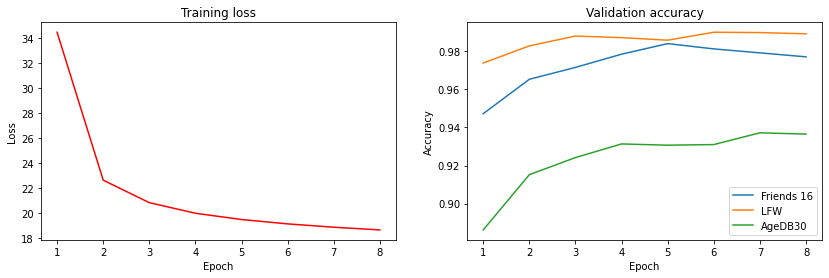

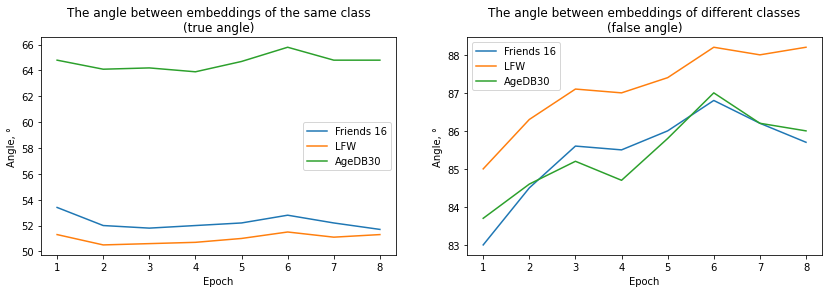


The model weights are saved in a file: ./checkpoints/stage_1.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/checkpoint (deflated 40%)
  adding: checkpoints/stage_1.ckpt.index (deflated 83%)
  adding: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)



**Model training - stage 2**

Learning rate: 0.005
Weight decay: 0.0005 

Epoch 1/6


In [ ]:
train()

**Model training - stage 2**

Learning rate: 0.005
Weight decay: 0.0005 

Epoch 1/6
22744/22744 - 5886s - loss: 18.4844
[Friends 16]  accuracy: 0.98333, true angle: 52.5°, false angle: 87.2°
[LFW]         accuracy: 0.99117, true angle: 51.3°, false angle: 88.1°
[AgeDB30]     accuracy: 0.94317, true angle: 64.7°, false angle: 86.3°
[Classifier]  accuracy: 0.99702, false rate: 10/3360, interval: 0.08107
Epoch 2/6
22744/22744 - 5865s - loss: 18.3300
[Friends 16]  accuracy: 0.97639, true angle: 51.9°, false angle: 85.6°
[LFW]         accuracy: 0.98983, true angle: 51.3°, false angle: 87.8°
[AgeDB30]     accuracy: 0.93717, true angle: 64.8°, false angle: 85.8°
[Classifier]  accuracy: 0.99554, false rate: 15/3360, interval: 0.08996
Epoch 3/6
22744/22744 - 5865s - loss: 18.1977
[Friends 16]  accuracy: 0.98403, true angle: 52.3°, false angle: 87.0°
[LFW]         accuracy: 0.99133, true angle: 51.8°, false angle: 88.5°
[AgeDB30]     accuracy: 0.93833, true angle: 65.6°, false angle: 86.8°
[Classifier]  accuracy: 0.99881, fa

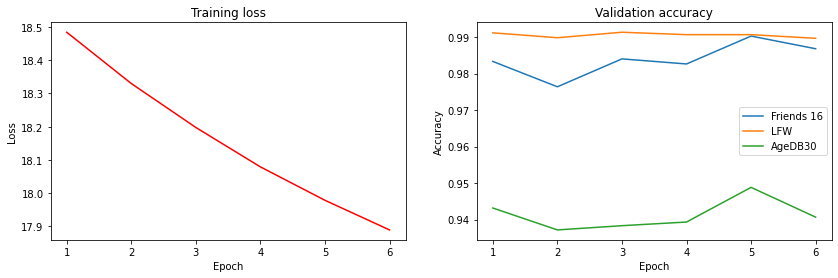

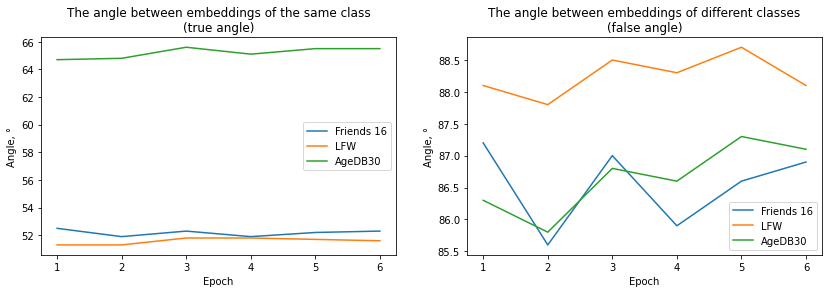


The model weights are saved in a file: ./checkpoints/stage_2.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
updating: checkpoints/ (stored 0%)
updating: checkpoints/checkpoint (deflated 40%)
updating: checkpoints/stage_1.ckpt.index (deflated 83%)
updating: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/stage_2.ckpt.index (deflated 83%)
  adding: checkpoints/stage_2.ckpt.data-00000-of-00001 (deflated 7%)



**Model training - stage 3**

Learning rate: 0.0025
Weight decay: 0.0005 

Epoch 1/8


In [ ]:
train()

**Model training - stage 3**

Learning rate: 0.0025
Weight decay: 0.0005 

Epoch 1/8
22744/22744 - 5891s - loss: 17.8070
[Friends 16]  accuracy: 0.98264, true angle: 52.4°, false angle: 85.7°
[LFW]         accuracy: 0.99150, true angle: 51.4°, false angle: 87.7°
[AgeDB30]     accuracy: 0.94383, true angle: 64.7°, false angle: 86.1°
[Classifier]  accuracy: 0.99464, false rate: 18/3360, interval: 0.08897
Epoch 2/8
22744/22744 - 5868s - loss: 17.7387
[Friends 16]  accuracy: 0.98125, true angle: 52.0°, false angle: 85.8°
[LFW]         accuracy: 0.99000, true angle: 51.6°, false angle: 88.1°
[AgeDB30]     accuracy: 0.94500, true angle: 65.1°, false angle: 86.9°
[Classifier]  accuracy: 0.99881, false rate: 4/3360, interval: 0.07587
Epoch 3/8
22744/22744 - 5870s - loss: 17.6732
[Friends 16]  accuracy: 0.98403, true angle: 52.2°, false angle: 85.9°
[LFW]         accuracy: 0.99167, true angle: 51.8°, false angle: 88.3°
[AgeDB30]     accuracy: 0.94567, true angle: 65.5°, false angle: 87.3°
[Classifier]  accuracy: 0.99881, fa

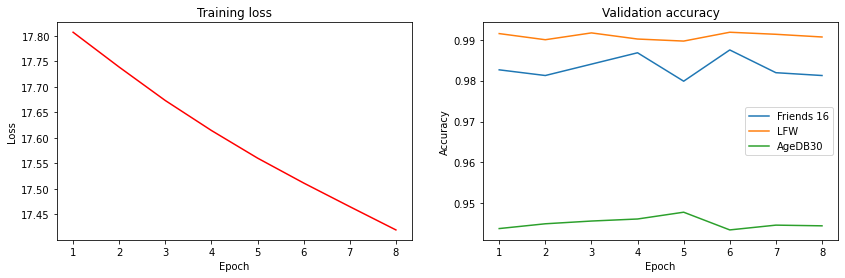

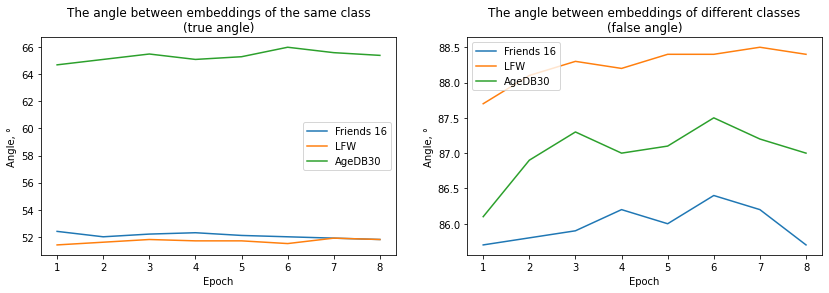


The model weights are saved in a file: ./checkpoints/stage_3.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
updating: checkpoints/ (stored 0%)
updating: checkpoints/checkpoint (deflated 40%)
updating: checkpoints/stage_1.ckpt.index (deflated 83%)
updating: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)
updating: checkpoints/stage_2.ckpt.index (deflated 83%)
updating: checkpoints/stage_2.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.index (deflated 83%)
  adding: checkpoints/weights_3.7.1.h5 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_3.8.1.h5 (deflated 7%)
  adding: checkpoints/weights_3.3.1.h5 (deflated 7%)
  adding: checkpoints/weights_3.2.1.h5 (deflated 7%)
  adding: checkpoints/weights_3.5.1.h5 (deflated 7%)
  adding: checkpoints/weights_3.1.1.h5 (de

**Model training - stage 4**

Learning rate: 0.001
Weight decay: 0.0005 

Epoch 1/10


In [ ]:
train()

In [ ]:
load_best_weights(model, 'weights_3.6.1.h5', purge=True)

The model weights are loaded from the file: checkpoints/weights_3.6.1.h5


**Model training - stage 4**

Learning rate: 0.001
Weight decay: 0.0005 

Epoch 1/10
[Friends 16]  accuracy: 0.99167, true angle: 52.3°, false angle: 86.9°
[LFW]         accuracy: 0.99200, true angle: 51.9°, false angle: 88.3°
[AgeDB30]     accuracy: 0.94683, true angle: 65.6°, false angle: 87.5°
[Classifier]  accuracy: 0.99911, false rate: 3/3360, interval: 0.03397

[Friends 16]  accuracy: 0.98333, true angle: 52.6°, false angle: 86.8°
[LFW]         accuracy: 0.99117, true angle: 51.7°, false angle: 88.3°
[AgeDB30]     accuracy: 0.94467, true angle: 65.6°, false angle: 87.4°
[Classifier]  accuracy: 0.99881, false rate: 4/3360, interval: 0.06642

[Friends 16]  accuracy: 0.98819, true angle: 51.7°, false angle: 86.1°
[LFW]         accuracy: 0.99100, true angle: 51.5°, false angle: 88.0°
[AgeDB30]     accuracy: 0.94517, true angle: 65.4°, false angle: 87.4°
[Classifier]  accuracy: 0.99792, false rate: 7/3360, interval: 0.04257
22744/22744 - 6144s - loss: 17.4624

[Friends 16]  accuracy: 0.98819, true angle: 52.5°, fa

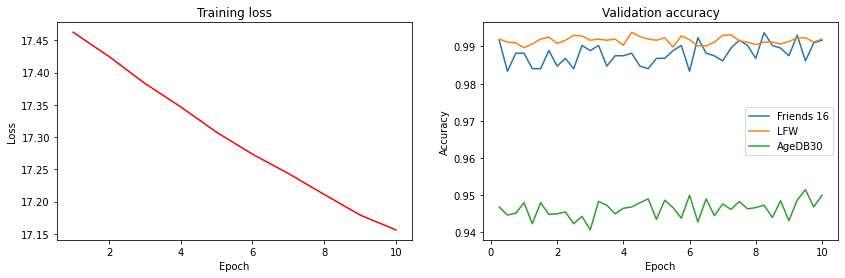

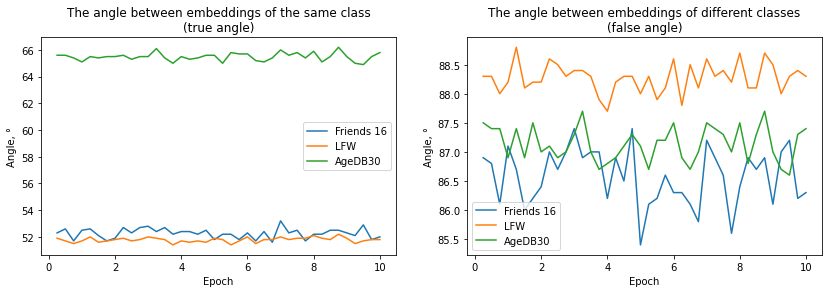


The model weights are saved in a file: ./checkpoints/stage_4.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/weights_4.10.4.h5 (deflated 7%)
  adding: checkpoints/weights_4.10.2.h5 (deflated 7%)
  adding: checkpoints/stage_2.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_4.5.4.h5 (deflated 7%)
  adding: checkpoints/weights_4.9.1.h5 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/stage_4.ckpt.index (deflated 83%)
  adding: checkpoints/weights_4.6.4.h5 (deflated 7%)
  adding: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.index (deflated 83%)
  adding: checkpoints/weights_4.6.1.h5 (deflated 7%)
  adding: checkpoints/weights_4.1.3.h5 (deflated 7%)
  adding: checkpoints/weights_4.8.4.h5 (deflated 7%)
  adding: checkpoints/weights_4.6.3.h5 (deflated 7%)
 

**Model training - stage 5**

Learning rate: 0.0001
Weight decay: 0.0005 

Epoch 1/10


In [ ]:
train()

In [ ]:
load_best_weights(model, 'weights_4.10.4.h5', purge=True)

The model weights are loaded from the file: checkpoints/weights_4.10.4.h5


**Model training - stage 5**

Learning rate: 0.0001
Weight decay: 1e-06 

Epoch 1/10
[Friends 16]  accuracy: 0.99236, true angle: 52.0°, false angle: 86.8°
[LFW]         accuracy: 0.99267, true angle: 51.5°, false angle: 88.5°
[AgeDB30]     accuracy: 0.94783, true angle: 64.9°, false angle: 87.0°
[Classifier]  accuracy: 0.99911, false rate: 3/3360, interval: 0.01056

[Friends 16]  accuracy: 0.99375, true angle: 52.4°, false angle: 87.6°
[LFW]         accuracy: 0.99133, true angle: 51.8°, false angle: 88.6°
[AgeDB30]     accuracy: 0.95167, true angle: 65.4°, false angle: 87.6°
[Classifier]  accuracy: 1.00000, false rate: 0/3360, interval: -0.00068

[Friends 16]  accuracy: 0.99306, true angle: 52.3°, false angle: 87.5°
[LFW]         accuracy: 0.99217, true angle: 51.5°, false angle: 88.3°
[AgeDB30]     accuracy: 0.95083, true angle: 64.5°, false angle: 87.1°
[Classifier]  accuracy: 1.00000, false rate: 0/3360, interval: -0.00565
22744/22744 - 6122s - loss: 9.5898

[Friends 16]  accuracy: 0.99306, true angle: 52.3°, f

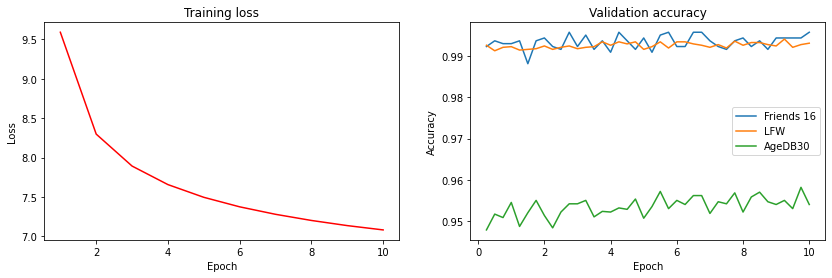

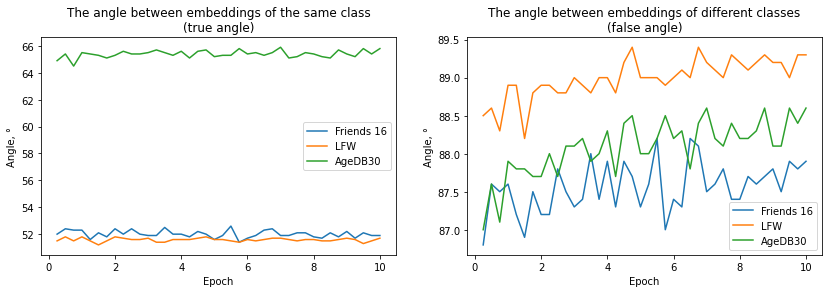


The model weights are saved in a file: ./checkpoints/stage_5.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/weights_5.8.4.h5 (deflated 7%)
  adding: checkpoints/weights_5.8.1.h5 (deflated 7%)
  adding: checkpoints/weights_4.10.4.h5 (deflated 7%)
  adding: checkpoints/weights_5.9.4.h5 (deflated 7%)
  adding: checkpoints/stage_2.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_5.3.3.h5 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/stage_4.ckpt.index (deflated 83%)
  adding: checkpoints/weights_5.2.4.h5 (deflated 7%)
  adding: checkpoints/weights_5.2.1.h5 (deflated 7%)
  adding: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_5.2.2.h5 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.index (deflated 83%)
  adding: checkpoints/weights_5.5.1.h5 (deflated 7%)
  

**Model training - stage 6**

Learning rate: 1e-05
Weight decay: 1e-06 

Epoch 1/10


In [ ]:
train()

In [ ]:
load_best_weights(model, 'weights_5.10.4.h5', purge=True)

The model weights are loaded from the file: ./checkpoints/weights_5.10.4.h5


**Model training - stage 6**

Learning rate: 1e-05
Weight decay: 1e-08 

Epoch 1/10
[Friends 16]  accuracy: 0.99375, true angle: 51.7°, false angle: 87.6°
[LFW]         accuracy: 0.99233, true angle: 51.6°, false angle: 89.3°
[AgeDB30]     accuracy: 0.95350, true angle: 65.4°, false angle: 88.4°
[F16 mtcnn]   accuracy: 0.98611, true angle: 52.6°, false angle: 87.6°
[LFW mtcnn]   accuracy: 0.99200, true angle: 52.5°, false angle: 89.3°
[Age mtcnn]   accuracy: 0.95133, true angle: 66.1°, false angle: 88.2°
[Classifier]  accuracy: 0.99911, false rate: 3/3360, interval: 0.02223
[Clf mtcnn]   accuracy: 0.99851, false rate: 5/3360, interval: 0.16646

[Friends 16]  accuracy: 0.99444, true angle: 52.4°, false angle: 88.1°
[LFW]         accuracy: 0.99333, true angle: 51.6°, false angle: 89.3°
[AgeDB30]     accuracy: 0.95550, true angle: 65.3°, false angle: 88.4°
[F16 mtcnn]   accuracy: 0.99097, true angle: 53.2°, false angle: 88.2°
[LFW mtcnn]   accuracy: 0.99167, true angle: 52.5°, false angle: 89.3°
[Age mtcnn]   accuracy

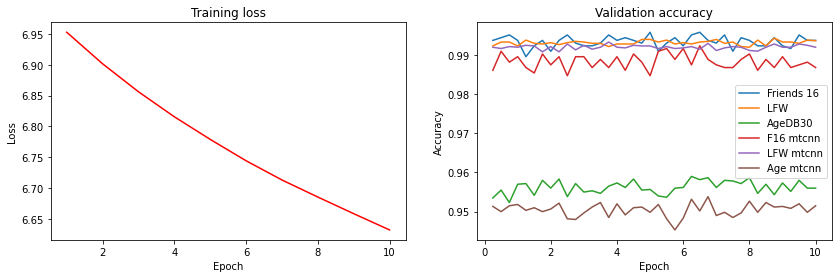

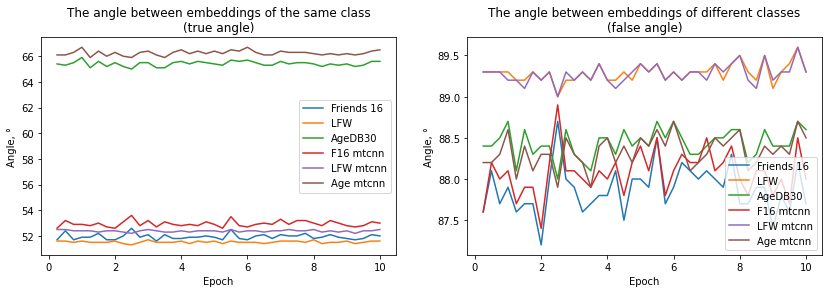


The model weights are saved in a file: ./checkpoints/stage_6.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/weights_4.10.4.h5 (deflated 7%)
  adding: checkpoints/stage_2.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_6.7.4.h5 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/stage_4.ckpt.index (deflated 83%)
  adding: checkpoints/weights_6.1.2.h5 (deflated 7%)
  adding: checkpoints/weights_6.10.1.h5 (deflated 7%)
  adding: checkpoints/weights_6.8.3.h5 (deflated 7%)
  adding: checkpoints/weights_6.7.3.h5 (deflated 7%)
  adding: checkpoints/stage_1.ckpt.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/weights_6.4.1.h5 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.index (deflated 83%)
  adding: checkpoints/weights_6.5.4.h5 (deflated 7%)
  adding: checkpoints/weights_6.2.1.h5 (deflated 7%)
 

In [ ]:
train()

# Transfer Learning & Fine Tuning

In [6]:
# 17 # Creating a model for Transfer Learning
plan = cfg['learn_plan']
model, inference, logist, backbone = CreateModel(
    cfg['net_type'], plan['train_head'], size=cfg['input_size'],
    num_classes=plan['num_classes'], margin=plan['margin'],
    logist_scale=plan['logist_scale'], embd_shape=cfg['embd_shape'],
    w_decay=cfg['w_decay'], training=True)

print(model.summary())

# Determining the last stage of training
stage, _ = checkpoint_stage(CHECKPOINTS_PATH)

Model: "recface_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
MobileFaceNetV2 (Functional)    (None, 1, 1, 512)    949632      input_image[0][0]                
__________________________________________________________________________________________________
OutputLayer (Functional)        (None, 512)          264704      MobileFaceNetV2[0][0]            
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
______________________________________________________________________________________

In [7]:
# 18 # Loading the training dataset
train_dataset, steps_per_epoch = load_dataset(cfg, plan)

Loading the training dataset: ms1mv2_bin_mtcnn_sq_continued.tfrecord


In [8]:
# 19 # Performing Transfer Learning
def learn():
  stage_max = len(cfg['train_plan']['plan']) + len(plan['plan'])
  stage_last = min(stage + len(plan['plan']) - 1, stage_max)
  stage_first = stage_last - len(plan['plan']) + 1
  for s in range(stage, stage_last + 1):
    printmd('**Model training - stage ' + str(s) + '**')
    stage_rec = plan['plan'][s - stage_first]

  #  if cfg['fine_tuning'] and s >= stage_last:
  #    print('The "Fine Tuning" stage. Defrost the weights.')
  #    inference.trainable = True
  #    backbone.trainable = True
  #  else:
  #    inference.trainable = False
  #    backbone.trainable = False

    train_stage(cfg, model, inference, logist, s, stage_rec, train_dataset,
                steps_per_epoch, plan['val_datasets'], plan['clf_datasets'])
    save_weights(model, logist, plan, s)

  print('\nThe training process is completed.')

In [ ]:
load_best_weights(model, 'weights_6.7.2.h5', purge=True)

The model weights are loaded from the file: ./checkpoints/weights_6.7.2.h5


**Model training - stage 7**

Learning rate: 1e-06
Weight decay: 1e-08 

Epoch 1/10
[Friends 16]  accuracy: 0.99375, true angle: 52.8°, false angle: 88.5°
[LFW]         accuracy: 0.99267, true angle: 52.2°, false angle: 89.6°
[AgeDB30]     accuracy: 0.95667, true angle: 66.0°, false angle: 88.9°
[F16 mtcnn]   accuracy: 0.99028, true angle: 53.7°, false angle: 88.6°
[LFW mtcnn]   accuracy: 0.99150, true angle: 53.3°, false angle: 89.7°
[Age mtcnn]   accuracy: 0.94783, true angle: 67.0°, false angle: 88.8°
[Classifier]  accuracy: 1.00000, false rate: 0/3360, interval: -0.00426
[Clf mtcnn]   accuracy: 0.99702, false rate: 10/3360, interval: 0.15569

[Friends 16]  accuracy: 0.99514, true angle: 52.7°, false angle: 88.5°
[LFW]         accuracy: 0.99283, true angle: 52.2°, false angle: 89.7°
[AgeDB30]     accuracy: 0.95550, true angle: 66.0°, false angle: 88.9°
[F16 mtcnn]   accuracy: 0.98958, true angle: 53.7°, false angle: 88.6°
[LFW mtcnn]   accuracy: 0.99167, true angle: 53.2°, false angle: 89.7°
[Age mtcnn]   accura

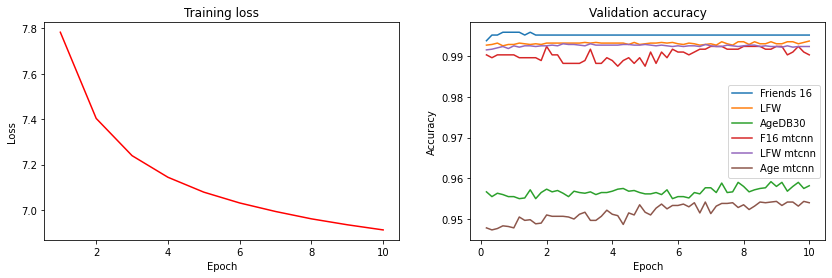

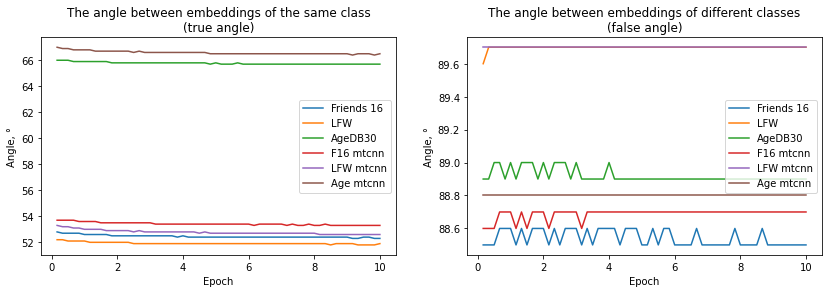


The model weights are saved in a file: ./checkpoints/stage_7.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/weights_7.5.6.h5 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/weights_7.8.5.h5 (deflated 7%)
  adding: checkpoints/weights_7.10.5.h5 (deflated 7%)
  adding: checkpoints/weights_7.9.5.h5 (deflated 7%)
  adding: checkpoints/checkpoint (deflated 40%)
  adding: checkpoints/weights_7.2.5.h5 (deflated 7%)
  adding: checkpoints/weights_7.5.1.h5 (deflated 7%)
  adding: checkpoints/weights_7.10.2.h5 (deflated 7%)
  adding: checkpoints/weights_7.5.2.h5 (deflated 7%)
  adding: checkpoints/weights_7.10.4.h5 (deflated 7%)
  adding: checkpoints/weights_7.3.2.h5 (deflated 7%)
  adding: checkpoints/stage_3.ckpt.index (deflated 83%)
  adding: checkpoints/weights_7.4.6.h5 (deflated 7%)
  adding: checkpoints/weights_7.7.5.h5 (

In [ ]:
learn()

In [9]:
load_best_weights(model, 'weights_7.8.6.h5', purge=True)

The model weights are loaded from the file: ./checkpoints/weights_7.8.6.h5


**Model training - stage 8**

Learning rate: 1e-07
Weight decay: 1e-09 

Epoch 1/10
[Friends 16]  accuracy: 0.99514, true angle: 52.3°, false angle: 88.5°
[LFW]         accuracy: 0.99350, true angle: 51.9°, false angle: 89.7°
[AgeDB30]     accuracy: 0.95700, true angle: 65.7°, false angle: 88.8°
[F16 mtcnn]   accuracy: 0.99236, true angle: 53.3°, false angle: 88.7°
[LFW mtcnn]   accuracy: 0.99250, true angle: 52.7°, false angle: 89.7°
[Age mtcnn]   accuracy: 0.95283, true angle: 66.5°, false angle: 88.8°
[Classifier]  accuracy: 1.00000, false rate: 0/3360, interval: -0.01772
[Clf mtcnn]   accuracy: 0.99851, false rate: 5/3360, interval: 0.19573

[Friends 16]  accuracy: 0.99514, true angle: 52.4°, false angle: 88.5°
[LFW]         accuracy: 0.99367, true angle: 51.9°, false angle: 89.7°
[AgeDB30]     accuracy: 0.95700, true angle: 65.7°, false angle: 88.9°
[F16 mtcnn]   accuracy: 0.99236, true angle: 53.3°, false angle: 88.7°
[LFW mtcnn]   accuracy: 0.99233, true angle: 52.7°, false angle: 89.7°
[Age mtcnn]   accurac

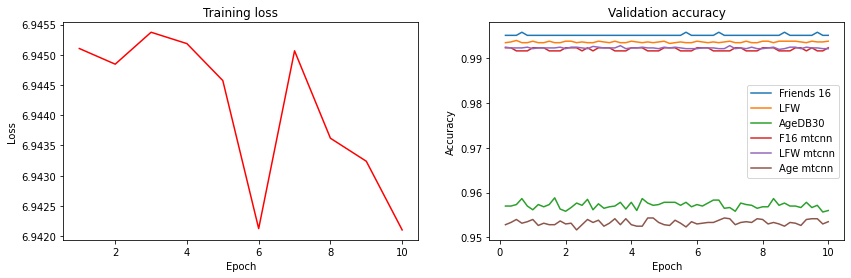

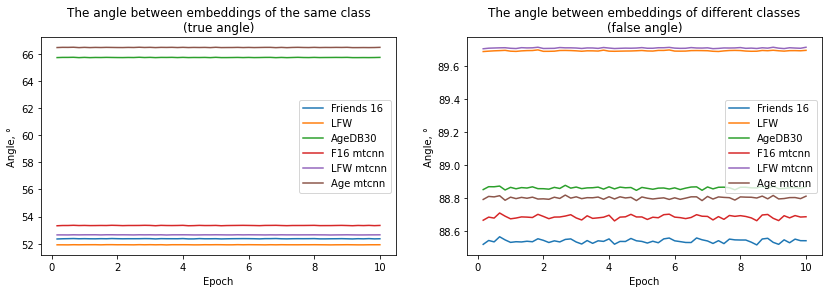


The model weights are saved in a file: ./checkpoints/stage_8.ckpt
Copying the weights "checkpoints_95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256.zip" to Google Drive ...
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/weights_8.8.2.h5 (deflated 7%)
  adding: checkpoints/weights_3.6.1.h5 (deflated 7%)
  adding: checkpoints/weights_8.6.6.h5 (deflated 7%)
  adding: checkpoints/stage_5.ckpt.index (deflated 83%)
  adding: checkpoints/weights_8.7.3.h5 (deflated 7%)
  adding: checkpoints/weights_8.9.5.h5 (deflated 7%)
  adding: checkpoints/weights_8.6.4.h5 (deflated 7%)
  adding: checkpoints/weights_7.8.6.h5 (deflated 7%)
  adding: checkpoints/stage_8.ckpt.data-00000-of-00001 (deflated 6%)
  adding: checkpoints/weights_8.9.1.h5 (deflated 7%)
  adding: checkpoints/weights_6.7.2.h5 (deflated 7%)
  adding: checkpoints/weights_8.10.3.h5 (deflated 7%)
  adding: checkpoints/weights_8.1.6.h5 (deflated 7%)
  adding: checkpoints/weights_8.7.5.h5 (deflated 7%)
  adding: checkpoints

In [10]:
learn()

In [11]:
load_best_weights(model, 'weights_8.3.6.h5')

The model weights are loaded from the file: ./checkpoints/weights_8.3.6.h5


# Testing

In [8]:
# 20 # Creating a model for testing
# This cell can be executed only after saving the model (cell 30)
inference = CreateModel(
    cfg['net_type'], None, size=cfg['input_size'],
    embd_shape=cfg['embd_shape'], w_decay=cfg['w_decay'], training=False)
print(inference.summary(), '\n')

# Loading the model weights
path = 'recface/{}_model.h5'.format(PROJECT_NAME)
inference.load_weights(path, by_name=True)
print('The model weights are loaded from the file:', path)

Model: "recface_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
MobileFaceNetV2 (Functional) (None, 1, 1, 512)         949632    
_________________________________________________________________
OutputLayer (Functional)     (None, 512)               264704    
Total params: 1,214,336
Trainable params: 1,193,984
Non-trainable params: 20,352
_________________________________________________________________
None 

The model weights are loaded from the file: recface/95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256_model.h5


In [ ]:
# 21 # (optional) Creating a "resnet50(MXNET)" model for a test comparison
# https://github.com/deepinsight/insightface
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
import warnings

test_binary_datasets = [
    {'name': 'Friends 16',
     'path': r'E:\Deep Learning\data\test\friends_16_test_aligned.bin'},
    {'name': 'LFW',
     'path': r'E:\Deep Learning\data\test\lfw_align_112\lfw.bin'},
    {'name': 'AgeDB30',
     'path': r'E:\Deep Learning\data\test\agedb_align_112\agedb_30.bin'},
    {'name': 'CFP-FP',
     'path': r'E:\Deep Learning\data\test\cfp_align_112\cfp_fp.bin'}]

cfg['embd_shape'] = 512
cfg['normalization'] = '0:255'
cfg['test_datasets'] = test_binary_datasets
cfg = setup_cfg(cfg)
MXNET_MODEL = 'models/model-r50-am-lfw/model'

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  inference = gluon.nn.SymbolBlock.imports(
      MXNET_MODEL + "-symbol.json", ['data'], MXNET_MODEL + "-0000.params",
      ctx=mx.gpu())

def decode_image(data):
  return mx.image.imdecode(data, to_rgb=0).asnumpy()

def predict(inference, x):
  x_rgb = np.empty_like(x)
  for i in range(len(x)):
    x_rgb[i] = cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB)
  with mx.Context(mx.gpu()):
    _x = nd.transpose(nd.array(x_rgb), axes=(0, 3, 1, 2))
  return inference.forward(_x).asnumpy()

In [ ]:
# 22 # (optional) Creating a "mobilefacenet-V2(MXNET)" model for a test comparison
# https://github.com/qidiso/mobilefacenet-V2
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
import warnings

test_binary_datasets = [
    {'name': 'Friends 16',
     'path': r'E:\Deep Learning\data\test\friends_16_test_aligned.bin'},
    {'name': 'LFW',
     'path': r'E:\Deep Learning\data\test\lfw_align_112\lfw.bin'},
    {'name': 'AgeDB30',
     'path': r'E:\Deep Learning\data\test\agedb_align_112\agedb_30.bin'},
    {'name': 'CFP-FP',
     'path': r'E:\Deep Learning\data\test\cfp_align_112\cfp_fp.bin'}]

cfg['embd_shape'] = 512
cfg['normalization'] = '0:255'
cfg['test_datasets'] = test_binary_datasets
cfg = setup_cfg(cfg)
MXNET_MODEL = 'models/mobilefacenet-V2/model'

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  inference = gluon.nn.SymbolBlock.imports(
      MXNET_MODEL + "-symbol.json", ['data'], MXNET_MODEL + "-0000.params",
      ctx=mx.gpu())

def predict(inference, x):
  x_rgb = np.empty_like(x)
  for i in range(len(x)):
    x_rgb[i] = cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB)
  with mx.Context(mx.gpu()):
    _x = nd.transpose(nd.array(x_rgb), axes=(0, 3, 1, 2))
  return inference.forward(_x).asnumpy()

In [ ]:
# 23 # (optional) Using the "face-recognition" library and pre-trained weights
import face_recognition

cfg['embd_shape'] = 128
cfg['normalization'] = '0:255'
cfg = setup_cfg(cfg)
inference = None

def predict(inference, x):
  embeds = []
  for i in range(len(x)):
    img = cv2.cvtColor(x[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
    emb = face_recognition.face_encodings(
        img, ((0, cfg['input_size'], cfg['input_size'], 0),))[0]
    embeds.append(emb)
  return np.array(embeds)

In [ ]:
# 24 # (optional) Creating a "OpenFace (FaceNet)" model for a test comparison
# https://github.com/iwantooxxoox/Keras-OpenFace
# https://github.com/cmusatyalab/openface
from tensorflow.keras.models import load_model

test_binary_datasets = [
    {'name': 'Friends 16',
     'path': r'E:\Deep Learning\data\test\friends_16_test_aligned.bin'},
    {'name': 'LFW',
     'path': r'E:\Deep Learning\data\test\lfw_align_112\lfw.bin'},
    {'name': 'LFW-OpenFace',
     'path': r'E:\Deep Learning\data\test\lfw-OpenFace\lfw-OpenFace.bin'},
    {'name': 'AgeDB30',
     'path': r'E:\Deep Learning\data\test\agedb_align_112\agedb_30.bin'},
    {'name': 'CFP-FP',
     'path': r'E:\Deep Learning\data\test\cfp_align_112\cfp_fp.bin'}]

cfg['embd_shape'] = 128
cfg['input_size'] = 96
cfg['normalization'] = '0:1'
cfg['test_datasets'] = test_binary_datasets
cfg = setup_cfg(cfg)

inference = load_model('Keras-OpenFace-master/OpenFace.h5')

def predict(inference, x):
  imgs = []
  for i in range(len(x)):
    img = cv2.resize(np.round(x[i] * 255).astype(np.uint8),
                     (cfg['input_size'], cfg['input_size']))
    imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255)
  return inference.predict_on_batch(np.array(imgs))


[*] Loading the dataset "Friends 16"
[*] Testing the dataset "Friends 16"


  0%|          | 0/180 [00:00<?, ?it/s]

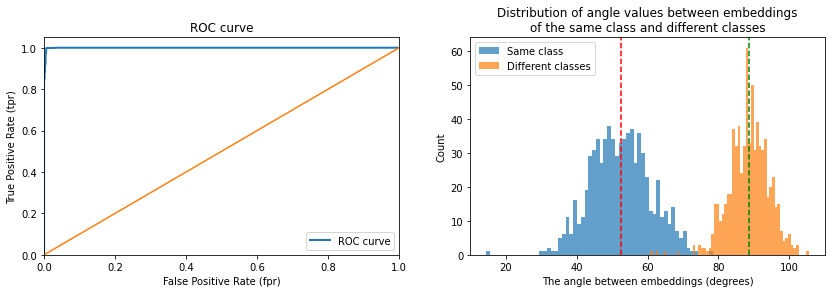

Accuracy: 0.99514
Best threshold: 1.389
Total images in the dataset: 2880
Number of pairs of images of the same class: 720
Number of pairs of images of different classes: 720
The average angle between embeddings of the same class: 52.4°
The average angle between embeddings of different classes: 88.5°


[*] Loading the dataset "LFW"
[*] Testing the dataset "LFW"


  0%|          | 0/750 [00:00<?, ?it/s]

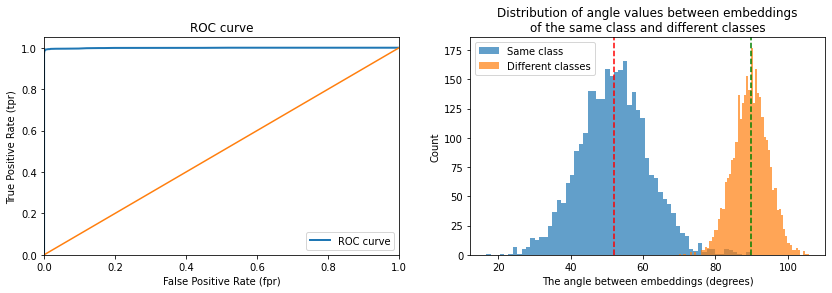

Accuracy: 0.99383
Best threshold: 1.529
Total images in the dataset: 12000
Number of pairs of images of the same class: 3000
Number of pairs of images of different classes: 3000
The average angle between embeddings of the same class: 51.9°
The average angle between embeddings of different classes: 89.7°


[*] Loading the dataset "AgeDB30"
[*] Testing the dataset "AgeDB30"


  0%|          | 0/750 [00:00<?, ?it/s]

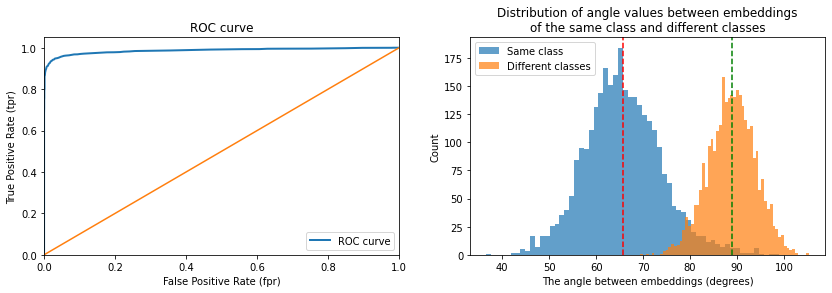

Accuracy: 0.95750
Best threshold: 1.618
Total images in the dataset: 12000
Number of pairs of images of the same class: 3000
Number of pairs of images of different classes: 3000
The average angle between embeddings of the same class: 65.7°
The average angle between embeddings of different classes: 88.9°



In [12]:
# 25 # Performing model tests
# Creating a face detector
create_face_detector(cfg)

# If the path to the image is specified, we get and save its embedding
if cfg['img_path'] is not None:
  print('Creating and saving the \"{}\" image embedding '
        'in \"./embeds.npy\"'.format(cfg['img_path']))
  img = load_image(cfg['img_path'])
  img = cv2.resize(img, (cfg['input_size'], cfg['input_size']))
  img = norm_binary(cfg, img)
  if len(img.shape) == 3:
    img = np.expand_dims(img, 0)
  embeds = l2_norm(predict(inference, img))
  np.save('./embeds.npy', embeds)

# Otherwise, we test the model with a set of validation datasets
elif 'test_datasets' in cfg:
  for ds in cfg['test_datasets']:
    print('\n[*] Loading the dataset \"{}\"'.format(ds['name']))
    data, issame = load_test_dataset(cfg, ds)

    print('[*] Testing the dataset \"{}\"'.format(ds['name']))
    tpr, fpr, accuracy, best_th, t_angles, f_angles = perform_val(
        cfg['embd_shape'], cfg['test_batch_size'], inference, data, issame,
        test_crop=cfg['test_crop'])
  
    plot_test_stats(len(data), tpr, fpr, accuracy, best_th,
                       t_angles, f_angles)
else:
  print('Test datasets are not defined. '
        'Configure the \"test_datasets\" parameter.')

# Freeing the face detector to free up the GPU memory
free_face_detector(cfg)

# Classifier Training

In [ ]:
# 26 # Getting embeddings for training the classifier
images, embeddings, label_list, ds_labels = get_dataset_embeddings(
    cfg, cfg['clf_train_dataset'], inference)

# Displaying images for training the classifier
cols = 8
label, image_list = None, []
for i, img in enumerate(images):
  if label_list[i] != label:
    plot_images(image_list, cols, cols)
    image_list = []
    label = label_list[i]
    print()
    printmd('**' + label + '**')
  image_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plot_images(image_list, cols, cols)

In [14]:
# 27 # Creating and training the classifier
le = LabelEncoder().fit(label_list)
label_idx = le.transform(label_list)

num_classes = len(le.classes_)
print('Training the classifier for {} classes and {} images.'
      .format(num_classes, len(label_idx)))

clf = create_classifier(cfg['clf_type'], embeddings, label_idx)

print('Saving the classifier to a file:', CLF_CLFER)
with open(CLF_CLFER, 'wb') as f:
  pickle.dump((le, clf), f)

print('Saving the dataset to a file:', CLF_DATA)
with open(CLF_DATA, 'wb') as f:
  pickle.dump((embeddings, label_list, label_idx, ds_labels), f)

Training the classifier for 16 classes and 320 images.
Saving the classifier to a file: classifier.pkl
Saving the dataset to a file: data.pkl


# Comparative testing of different types of classifiers

In [15]:
# 28 # Loading the classifier
with open(CLF_CLFER, 'rb') as f:
  (le, _) = pickle.load(f)

# Loading the dataset
with open(CLF_DATA, 'rb') as f:
  (train_embeddings, train_label_list, train_label_idx,
   train_ds_labels) = pickle.load(f)

# Getting images and embeddings for testing the classifier
images, embeddings, label_list, ds_labels = get_dataset_embeddings(
    cfg, cfg['clf_test_dataset'], inference)
ds_labels.remove(CLF_OTHERS)

for c in ('svc_lin', 'svc_rbf', 'knc', 'rfc', 'gscv',
          'pearson', 'cosine', 'l2', 'l1'):
  clf = create_classifier(c, train_embeddings, train_label_idx)
  _ = test_classifier(clf, le, c, images, embeddings, label_list, ds_labels,
                      train_embeddings, train_label_idx, verbose=2)

There are 17 labels found in the "test_photos14_dlib/test" directory.


  0%|          | 0/17 [00:00<?, ?it/s]

**The "svc_lin" classifier test**

Intersection interval: -0.0184
The number of false recognitions: 0 / 3360
Classifier accuracy: 1.0 



**The "svc_rbf" classifier test**

Intersection interval: 0.0641
The number of false recognitions: 4 / 3360
Classifier accuracy: 0.99881 



**The "knc" classifier test**

Intersection interval: 0.3847
The number of false recognitions: 461 / 3360
Classifier accuracy: 0.862798 



**The "rfc" classifier test**

Intersection interval: 0.08
The number of false recognitions: 13 / 3360
Classifier accuracy: 0.996131 



**The "gscv" classifier test**

Intersection interval: 0.0837
The number of false recognitions: 3 / 3360
Classifier accuracy: 0.999107 



**The "pearson" classifier test**

Intersection interval: 0.08
The number of false recognitions: 4 / 3360
Classifier accuracy: 0.99881 



**The "cosine" classifier test**

Intersection interval: 0.085
The number of false recognitions: 4 / 3360
Classifier accuracy: 0.99881 



**The "l2" classifier test**

Intersection interval: 0.0808
The number of false recognitions: 4 / 3360
Classifier accuracy: 0.99881 



**The "l1" classifier test**

Intersection interval: 1.2198
The number of false recognitions: 4 / 3360
Classifier accuracy: 0.99881 



# Testing the selected classifier type

In [16]:
# 29 # Loading the classifier
with open(CLF_CLFER, 'rb') as f:
  (le, clf) = pickle.load(f)

# Loading the dataset
with open(CLF_DATA, 'rb') as f:
  (train_embeddings, train_label_list, train_label_idx,
   train_ds_labels) = pickle.load(f)

# Getting images and embeddings for testing the classifier
images, embeddings, label_list, ds_labels = get_dataset_embeddings(
    cfg, cfg['clf_test_dataset'], inference)
ds_labels.remove(CLF_OTHERS)

_ = test_classifier(clf, le, cfg['clf_type'], images, embeddings, label_list,
                    ds_labels, train_embeddings, train_label_idx)

There are 17 labels found in the "test_photos14_dlib/test" directory.


  0%|          | 0/17 [00:00<?, ?it/s]

**The "svc_lin" classifier test**

<u>Using main images:</u>

Image "Андрей" recognized as "Андрей". The probability value: 0.7340
Image "Андрей" recognized as "Андрей". The probability value: 0.6955
Image "Андрей" recognized as "Андрей". The probability value: 0.6350
Image "Андрей" recognized as "Андрей". The probability value: 0.6961
Image "Андрей" recognized as "Андрей". The probability value: 0.6463
Image "Андрей" recognized as "Андрей". The probability value: 0.7167
Image "Андрей" recognized as "Андрей". The probability value: 0.7176
Image "Андрей" recognized as "Андрей". The probability value: 0.6883
Image "Андрей" recognized as "Андрей". The probability value: 0.6959
Image "Андрей" recognized as "Андрей". The probability value: 0.6804
Image "Блудный" recognized as "Блудный". The probability value: 0.6121
Image "Блудный" recognized as "Блудный". The probability value: 0.6464
Image "Блудный" recognized as "Блудный". The probability value: 0.5633
Image "Блудный" recognized as "Блудный". The probability value: 0.6869
Image "Блудный" recognized

<u>Using other people's (Others) images:</u>

Average value of the probability: 0.1355
Standard deviation value of the probability: 0.0301
Maximum value of the probability: 0.2963
Minimum value of the probability: 0.0842 

Median value of probability: 0.3084
Intersection interval: -0.0242
The number of false recognitions: 0 / 3360
Classifier accuracy: 1.0 



# Serializing and saving the model

In [17]:
# 30 # Saving the model and copying it to Google Drive
model_path = 'recface'
saved_model_path = os.path.join(model_path, '1')
db_path = 'drive/My Drive/Colab Notebooks/db/diplom'
proceed = True
if os.path.exists(model_path):
  if confirm_prompt('\nThe \"{}\" directory already exists. '
                    'Overwrite it ? (y/n)'.format(model_path)):
    shutil.rmtree(model_path)
  else:
    proceed = False

if proceed:
  logging.disable(logging.WARNING)
  tf.saved_model.save(inference, saved_model_path)
  logging.disable(logging.NOTSET)
  inference.save(os.path.join(model_path, PROJECT_NAME + '_model.h5'))
  save_frozen_graphs(inference, model_path, PROJECT_NAME + '_model.pb')
  zip_file = PROJECT_NAME + '_model.zip'
  if os.name == 'nt':
    !"c:\Program Files\7-Zip\7z.exe" a -tzip "{zip_file}" "{model_path}" > nul
  else:
    !zip -r "{zip_file}" "{model_path}"
    #!cp "{zip_file}" "{db_path}"
  print('\nThe model is saved in the archive:', zip_file)

  adding: recface/ (stored 0%)
  adding: recface/95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256_model.h5 (deflated 12%)
  adding: recface/95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256_model.pb (deflated 9%)
  adding: recface/1/ (stored 0%)
  adding: recface/1/saved_model.pb (deflated 93%)
  adding: recface/1/assets/ (stored 0%)
  adding: recface/1/variables/ (stored 0%)
  adding: recface/1/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: recface/1/variables/variables.index (deflated 78%)

The model is saved in the archive: 95_dlib_continued_MobileFaceNetV2_ArcFace_planH_batch256_model.zip
